# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"

This notebook reports the results of preliminary runs for the scenarios defined in the table [here](https://docs.google.com/document/d/1ssc5ilxEhEYYjFDCo5cIAgP7zSRcO4uVUXjxbyfR88Q/edit?tab=t.0). In this notebook, a single scenario is analyzed. Another notebook is available for multi-scenario comparison.

**Scenarios Analyzed:**
- *Scenario 1: [Brief Description]*
- *Scenario 2: [Brief Description]*
- *Scenario 10: [Brief Description]*

---

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA network data for each scenario.*

### 1.1. Import Libraries

In [1]:
# install plotly if not already installed
try:
    import plotly
except ImportError:
    !pip install plotly -qq


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry

import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from pathlib import Path

import cartopy.crs as ccrs # For plotting maps
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.patches import Wedge
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import plotly.express as px
import plotly.graph_objects as go

from shapely.geometry import LineString
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import yaml

import warnings
warnings.filterwarnings("ignore")

from _helpers import (
    attach_grid_region_to_buses, attach_state_to_buses, compute_demand,
    compute_data_center_load, compute_carrier_costs, fill_missing_color,
    fill_missing_nice_names, update_ac_dc_bus_coordinates, assign_location,
    compute_h2_capacities, plot_h2_capacities_bar, plot_electricity_dispatch
    )

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



### 1.2. Load Solved Network(s)

Scenario 1 is used as default for the analysis. Please change the number in `scenario_dir` to analyze a different scenario. The base year results are common for all the scenarios.

In [3]:
scenario_list = [1, 2, 6, 10] # 3, 4, 5] # List of scenarios to analyze
horizon_list = [2030] # List of horizons to analyze

networks = {}

project_root = os.getcwd()
results_dir = os.path.join(os.getcwd(), 'results')

# Load Base scenario
base_path = os.path.join(results_dir, 'US_base_year', "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc")
networks['Base_2023'] = pypsa.Network(base_path)

# Load networks for each scenario and horizon
for i in scenario_list:
    scenario_dir = f"US_scenario_{i:02d}"
    postnetworks_dir = os.path.join(results_dir, scenario_dir, "postnetworks")
    for horizon in horizon_list:
        # Construct the file path based on scenario and horizon
        file_path = os.path.join(postnetworks_dir, f'elec_s_100_ec_lcopt_3H_3H_{horizon}_0.071_AB_10export.nc')
        
        # Load the network
        networks[f'scenario_{i:02d}_{horizon}'] = pypsa.Network(file_path)

network_names = list(networks.keys())

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [54]:
project_root = os.getcwd()

In [5]:
grid_region_shapes_path = os.path.join(project_root, "needs_grid_regions_aggregated.geojson")
state_shapes_path = os.path.join(project_root, "gadm41_USA_1.json")

regions_onshore = gpd.read_file(grid_region_shapes_path)

In [6]:
with open('plotting.yaml', 'r') as file:
    plotting = yaml.safe_load(file)

tech_colors = plotting['tech_colors']
nice_names = plotting['nice_names']
rename_techs = plotting['rename_tech']
rename_tech_colors = plotting['renamed_tech_colors']

In [7]:
for network in networks.keys():
    networks[network] = attach_grid_region_to_buses(networks[network], grid_region_shapes_path)
    networks[network] = attach_state_to_buses(networks[network], state_shapes_path)

---

## 2. Input Data Analysis & Validation

*Before diving into results, we validate and visualize the key input data that drives the model. This primarily focuses on electricity demand.*

### 2.1. Demand Projections & Overview
*A summary of the overall demand assumptions for the model years.*

In [8]:
# Code to extract and display demand assumptions
# e.g., total annual TWh demand per country
pass

### 2.2. Country-wise Total Electricity Demand (Time Series)
*This plot shows the electricity demand profile over the year for each country, which is a primary driver for the system's operation.*

In [9]:
networks.keys()

dict_keys(['Base_2023', 'scenario_01_2030', 'scenario_02_2030', 'scenario_06_2030', 'scenario_10_2030'])

In [10]:
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]
static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
dynamic_load_carriers = ["AC", "services electricity", "land transport EV"]

demand = pd.DataFrame(columns=networks.keys(), index=dynamic_load_carriers+static_load_carriers+["total demand"])
demand_profile = pd.DataFrame(columns=networks.keys(), index=networks["Base_2023"].snapshots)
ac_load, services_load, ev_load = 0, 0, 0

for name, n in networks.items():

    # calculate static loads and its profile
    nhours = n.snapshot_weightings.objective.sum()
    static_totals = (
        n.loads.groupby("carrier")
            .sum().p_set
            .reindex(static_load_carriers)
            .fillna(0)
    )
    static_load_twh = static_totals.sum() * nhours / 1e6

    process_links = n.links[n.links.carrier.isin(target_processes)]
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index

    ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

    ac_loads = n.loads[n.loads.carrier == "AC"]
    industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
    ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
    ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
    ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

    # calculate dynamic loads and profiles
    # ac_loads = n.loads.query("carrier in 'AC'").index
    # ac_profile = n.loads_t.p_set[ac_loads].sum(axis=1)
    # ac_load = ac_profile.multiply(n.snapshot_weightings.objective, axis=0).sum() / 1e6

    # 3. Services & EV
    serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
                if i in n.loads_t.p_set.columns]
    ev_idx   = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
                if i in n.loads_t.p_set.columns]

    serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
    ev_profile   = n.loads_t.p_set[ev_idx].sum(axis=1)   if ev_idx else 0

    serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
    ev_twh   = (ev_profile   * n.snapshot_weightings.objective).sum() / 1e6

    # 4. Industry electricity total = static + industrial AC
    industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
    industry_elec_twh = industry_static_twh + ind_ac_twh

    dynamic_profile = ac_profile + serv_profile + ev_profile
    demand_profile.loc[:, name] = dynamic_profile + static_totals.sum()

    demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
    demand.loc["agriculture electricity",      name] = static_totals.get("agriculture electricity",  0) * nhours / 1e6
    demand.loc["industry electricity",         name] = industry_elec_twh
    demand.loc["AC",                           name] = ac_twh
    demand.loc["services electricity",         name] = serv_twh
    demand.loc["land transport EV",            name] = ev_twh
    demand.loc["total demand",                 name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh
    )


In [11]:
from IPython.display import display
display(demand)

Base_2023 scenario_01_2030 scenario_02_2030  \
AC                          1399.790281      1490.519908      1490.519908   
services electricity        1338.936409      1386.508012      1386.508012   
land transport EV             69.576977       318.254464       318.254464   
rail transport electricity       5.5476           5.5476           5.5476   
agriculture electricity         57.3213          57.3213          57.3213   
industry electricity         804.420936       886.717069       886.717069   
total demand                3675.593503      4144.868353      4144.868353   

                           scenario_06_2030 scenario_10_2030  
AC                              1490.519908      1490.519908  
services electricity            1386.508012      1386.508012  
land transport EV                318.242518       318.254464  
rail transport electricity           5.5476           5.5476  
agriculture electricity             57.3213          57.3213  
industry electricity             886.717069       886.717069  
total demand                    4144.856408      4144.868353

In [12]:
network_names

['Base_2023',
 'scenario_01_2030',
 'scenario_02_2030',
 'scenario_06_2030',
 'scenario_10_2030']

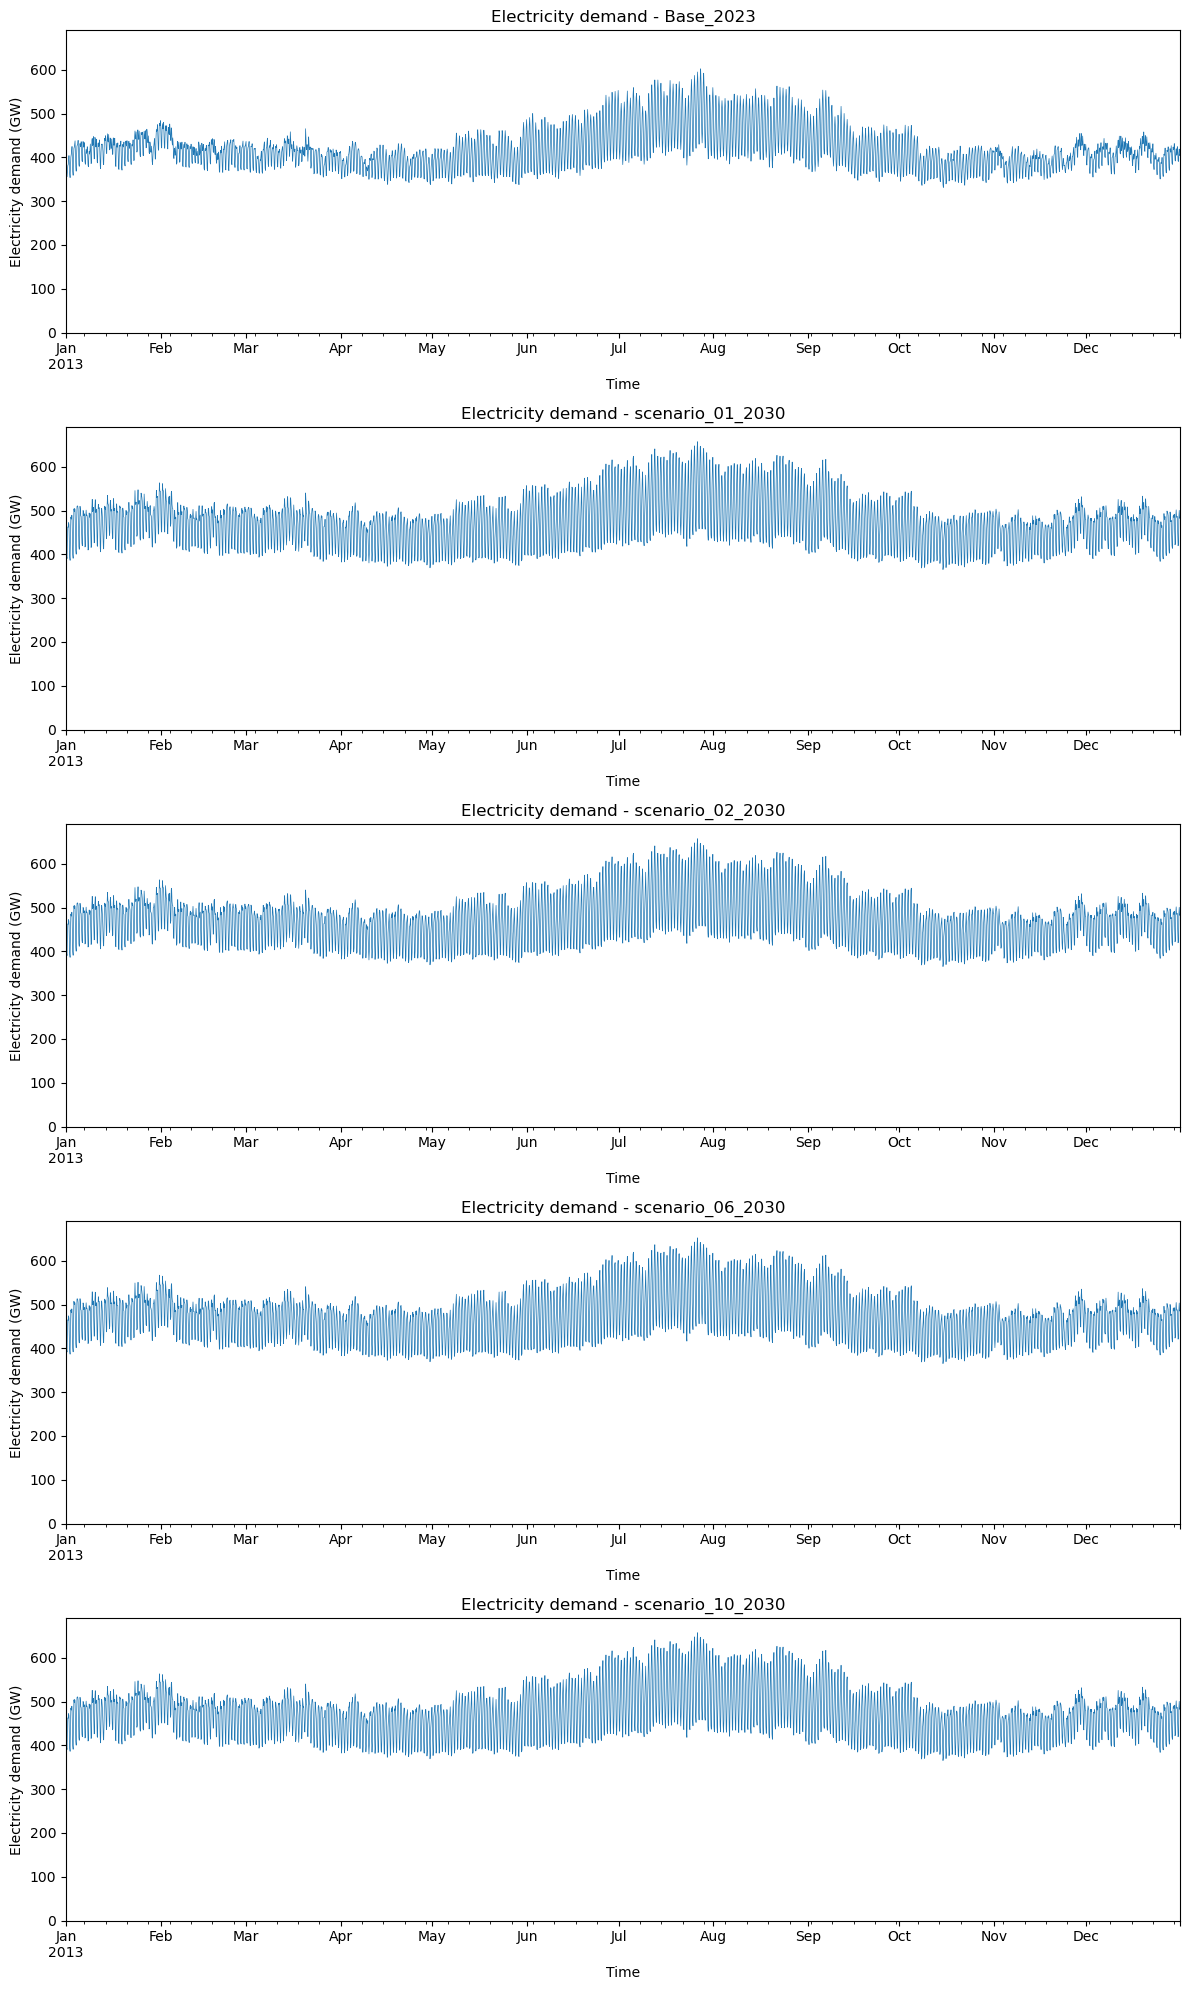

In [13]:
# Plotting electricity demand profiles for each network
fig, axes = plt.subplots(nrows=len(network_names), ncols=1, figsize=(12, 4 * len(network_names)))

y_max = (demand_profile / 1e3).max().max() * 1.05

for ax, name in zip(axes, network_names):
    cols = [col for col in demand_profile.columns]
    if cols:
        (demand_profile[name] / 1e3).plot(ax=ax, linewidth=0.5, legend = False)
        ax.set_title(f"Electricity demand - {name}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Electricity demand (GW)")
        ax.set_ylim(0, y_max)
    else:
        ax.set_visible(False)

plt.tight_layout()

### 2.3. State-wise Total Electricity Demand (Validation Year)
*A bar plot showing the total annual electricity demand for each state or region for the validation year. This helps confirm the spatial distribution of demand.*

In [14]:
base_demand_grid_region, base_demand_state = compute_demand(networks["Base_2023"])

In [15]:
base_demand_grid_region.T

region                      Alaska  California  Delta  Florida  Hawaii  \
carrier                                                                  
AC                            1.26      102.02  57.89    80.28    3.56   
agriculture electricity       0.05        5.29   1.59     2.89    0.16   
industry electricity          0.94       66.54  38.79    23.17    2.46   
land transport EV             0.06        6.34   1.86     3.32    0.19   
rail transport electricity    0.00        0.52   0.16     0.28    0.02   
services electricity          1.14       92.81  52.68    73.04    3.24   

region                      Mid-Atlantic  Midwest  Mountain  New England  \
carrier                                                                    
AC                                298.50   178.02     39.76        32.26   
agriculture electricity             9.23     7.64      2.94         2.00   
industry electricity              135.94    96.52     31.38        29.72   
land transport EV                  11.27     9.53      3.65         2.49   
rail transport electricity          0.89     0.75      0.30         0.20   
services electricity              271.56   161.99     36.18        29.36   

region                      New York  Northwest  Plains  Southeast  Southwest  \
carrier                                                                         
AC                             73.75      76.83  110.49     206.30      58.97   
agriculture electricity         4.63       2.50    4.91       7.05       2.70   
industry electricity           75.22      26.61   57.86      65.37      21.24   
land transport EV               5.75       3.10    6.07       8.33       3.24   
rail transport electricity      0.45       0.24    0.48       0.70       0.27   
services electricity           67.11      69.89  100.52     187.68      53.65   

region                       Texas  
carrier                             
AC                          151.80  
agriculture electricity       3.78  
industry electricity         60.67  
land transport EV             4.40  
rail transport electricity    0.37  
services electricity        138.11

In [16]:
base_demand_state.T

region                        AK     AL    AR     AZ      CA     CO     DE  \
carrier                                                                      
AC                          1.26  25.09  9.56  30.75  107.06  17.52  22.48   
agriculture electricity     0.05   0.74  0.22   1.36    6.81   0.78   1.41   
industry electricity        0.94   9.79  2.38   9.42   81.83   8.16  28.04   
land transport EV           0.06   0.86  0.26   1.62    8.21   0.99   1.71   
rail transport electricity  0.00   0.08  0.02   0.14    0.67   0.08   0.14   
services electricity        1.14  22.82  8.70  27.98   97.40  15.94  20.45   

region                         FL     GA    HI  ...     PA     SC    SD  \
carrier                                         ...                       
AC                          80.28  57.46  3.56  ...  39.34  28.83  3.07   
agriculture electricity      2.89   2.28  0.16  ...   2.08   1.10  0.19   
industry electricity        23.17  18.17  2.46  ...  27.13   9.24  2.18   
land transport EV            3.32   2.66  0.19  ...   2.56   1.31  0.23   
rail transport electricity   0.28   0.22  0.02  ...   0.20   0.11  0.02   
services electricity        73.04  52.27  3.24  ...  35.79  26.23  2.79   

region                         TN      TX     UT     VA     WA     WI    WY  
carrier                                                                      
AC                          46.92  173.36  11.19  93.34  32.30  23.72  3.85  
agriculture electricity      1.60    4.57   0.38   1.28   1.01   1.35  0.06  
industry electricity        16.95   68.87   3.44  15.18  13.92  15.17  1.25  
land transport EV            1.91    5.34   0.47   1.54   1.25   1.72  0.07  
rail transport electricity   0.16    0.45   0.04   0.12   0.10   0.13  0.01  
services electricity        42.69  157.72  10.18  84.92  29.38  21.59  3.51  

[6 rows x 45 columns]

In [17]:
fig1 = px.bar(base_demand_grid_region, barmode='stack', text_auto='.1f')
fig1.update_layout(width=1000, yaxis_title='Demand (TWh)', xaxis_title='Grid region', title='Electricity Demand by Carrier and Grid region (2023)')
fig1.show()

fig1 = px.bar(base_demand_state, barmode='stack', text_auto='.1f')
fig1.update_layout(width=1000, yaxis_title='Demand (TWh)', xaxis_title='State', title='Electricity Demand by Carrier and State (2023)')
fig1.show()

### 2.4. Data Center Loads/Demands
*Isolating and visualizing the specific demand profile of data centers to understand their impact on the system.*

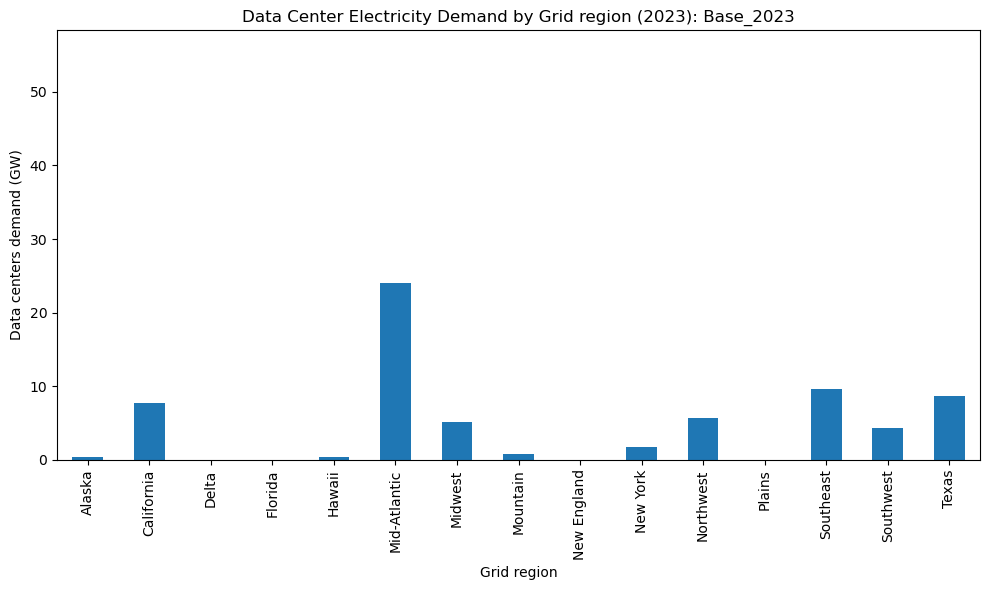

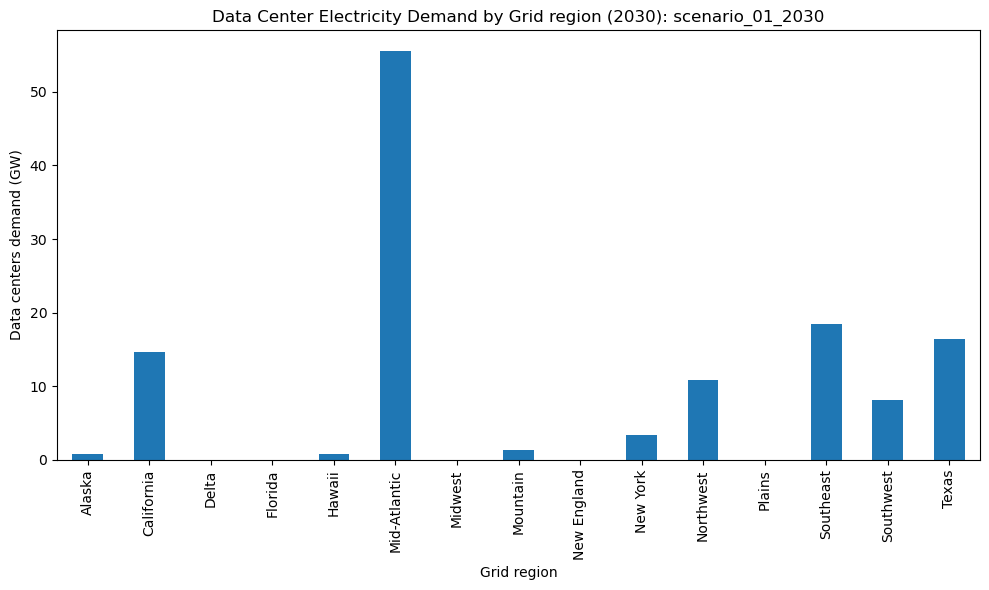

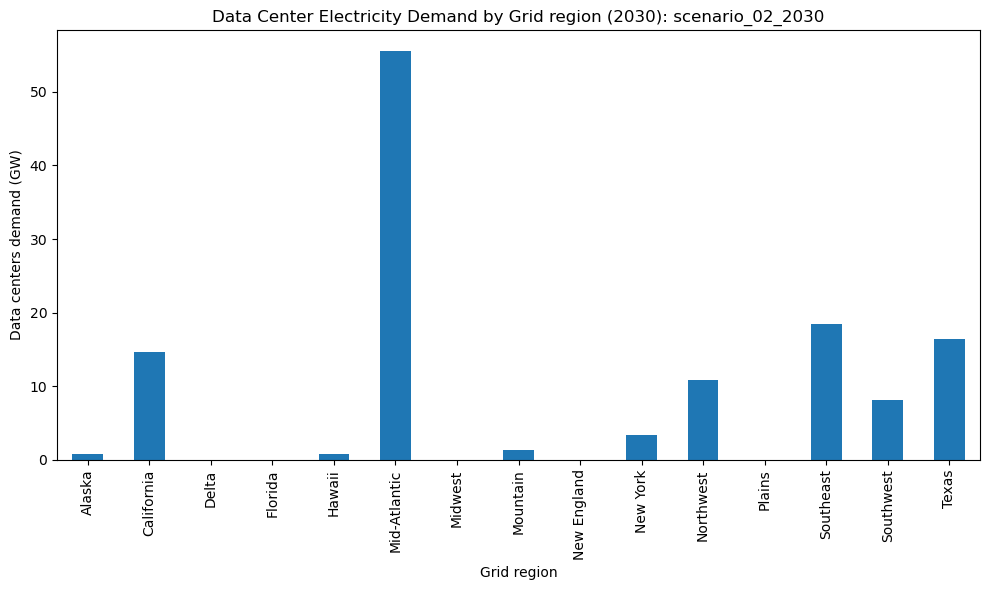

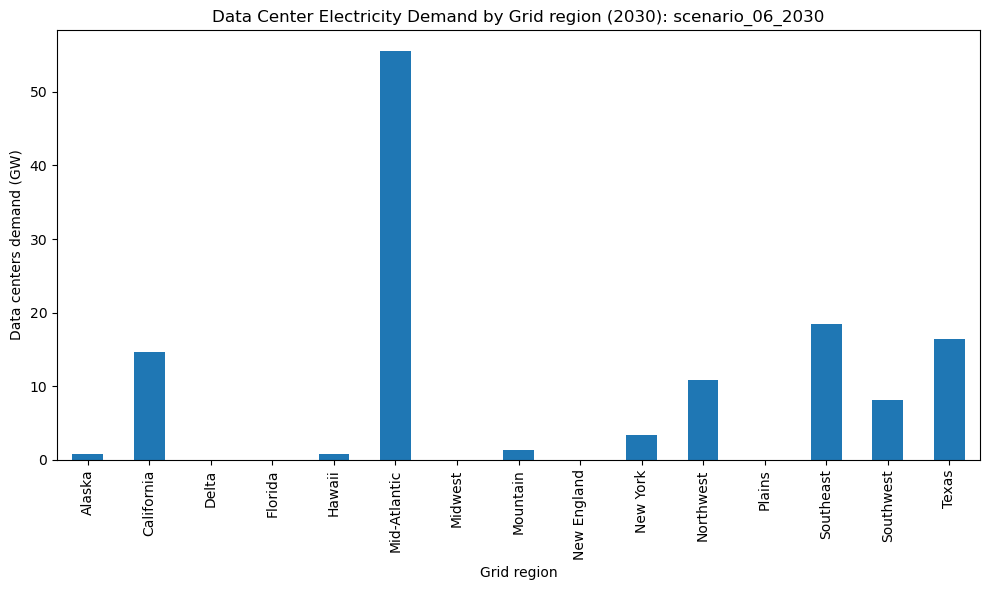

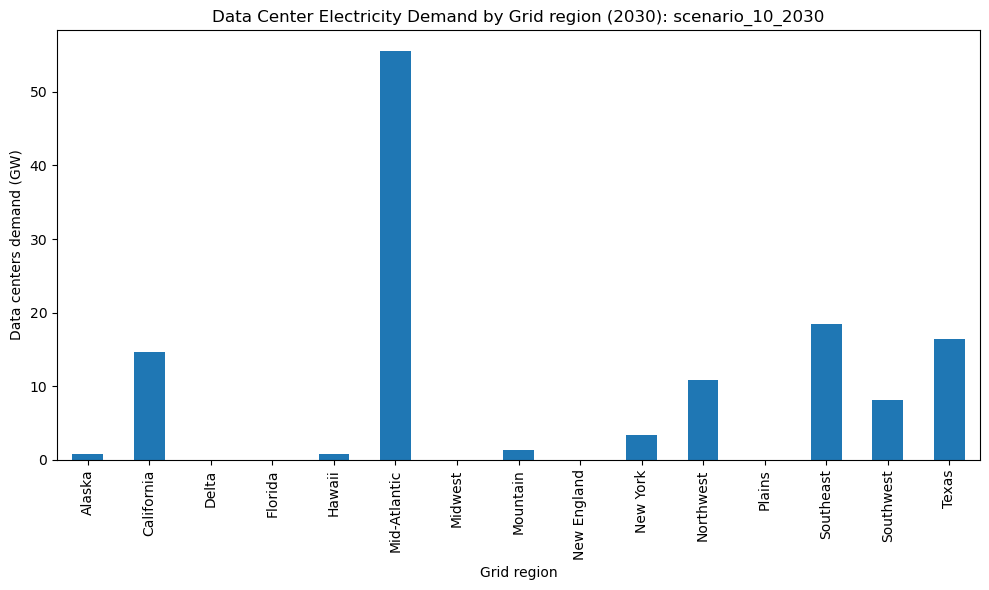

In [18]:
data_center_load = {}
for key, net in networks.items():
    data_center_load[key] = compute_data_center_load(net)

max_val = 0
for df in data_center_load.values():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    max_val = max(max_val, demand_by_grid_region.max())

for idx, (key, df) in enumerate(data_center_load.items()):
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"
    
    ax = demand_by_grid_region.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by Grid region ({year}): {network_names[idx]}",
        ylabel="Data centers demand (GW)",
        xlabel="Grid region",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()


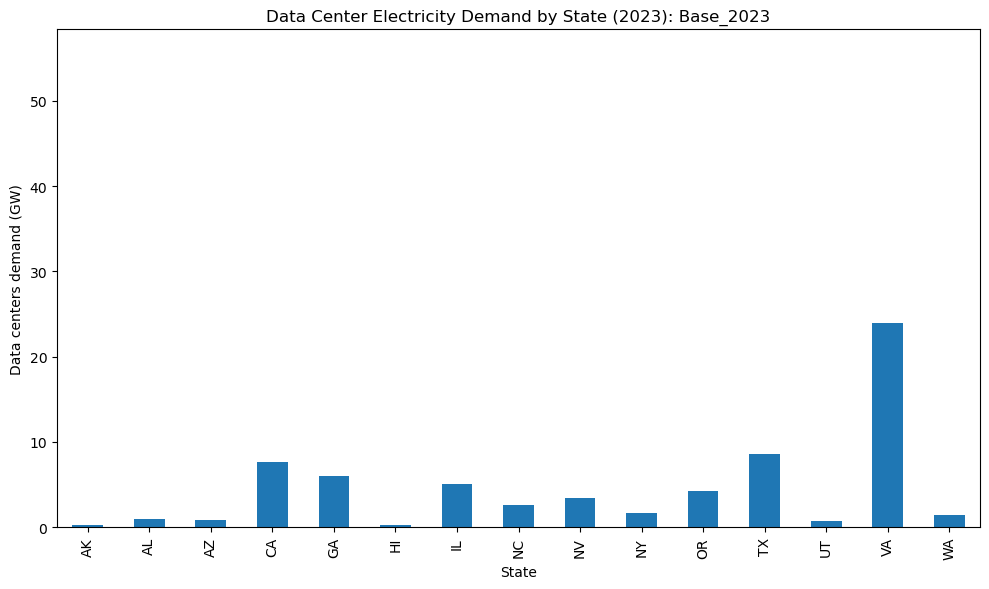

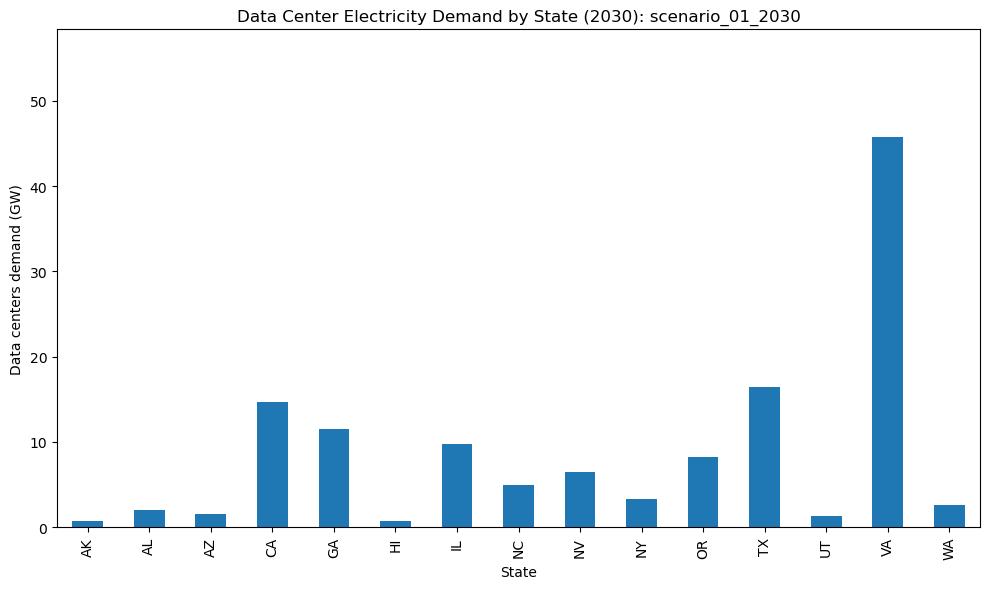

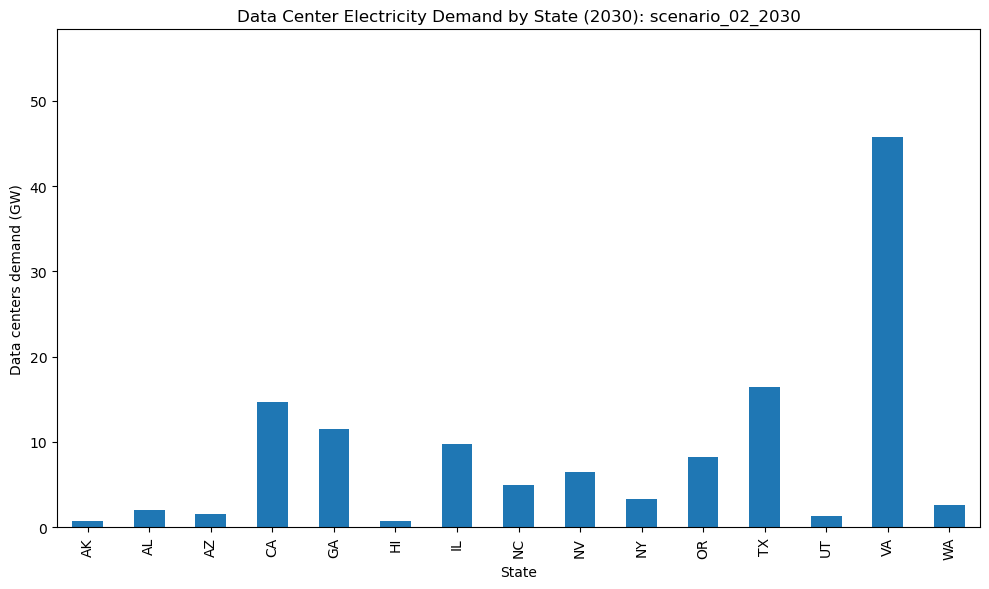

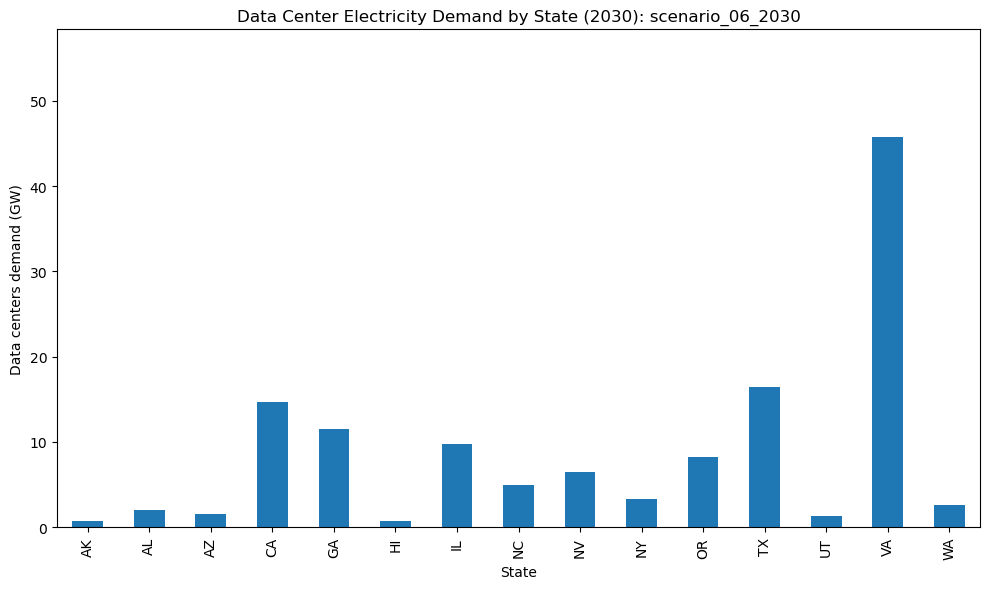

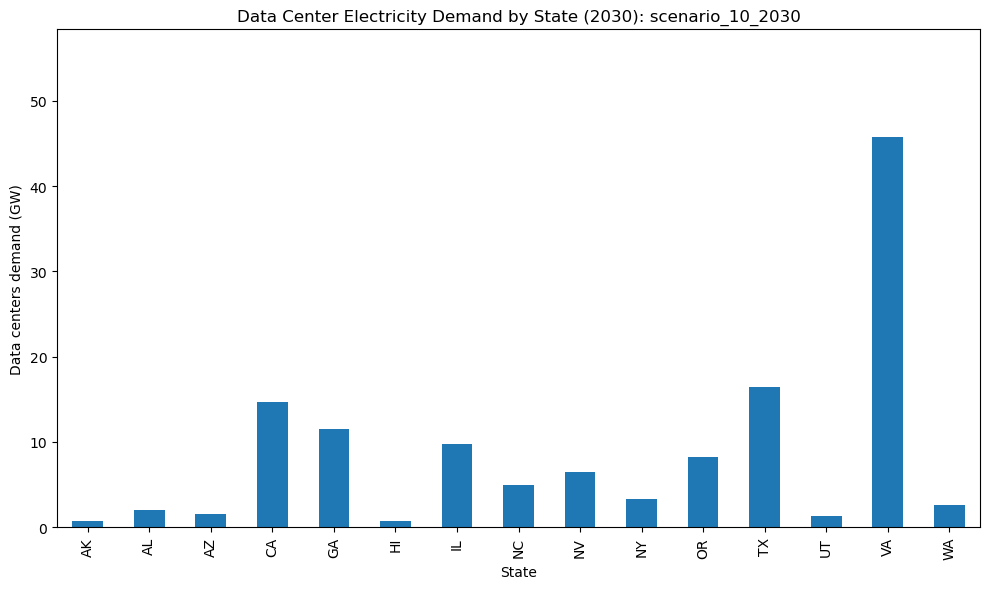

In [19]:
for idx, (key, df) in enumerate(data_center_load.items()):
    demand_by_state = df.groupby("state")["p_set"].sum().div(1e3)
    demand_by_state = demand_by_state[demand_by_state > 0]

    if demand_by_state.empty:
        print(f"No demand data for {key}")
        continue

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"

    ax = demand_by_state.plot(
        kind="bar",
        title=f"Data Center Electricity Demand by State ({year}): {network_names[idx]}",
        ylabel="Data centers demand (GW)",
        xlabel="State",
        figsize=(10, 6),
        legend=False
    )
    ax.set_ylim(0, max_val * 1.05)
    plt.tight_layout()
    plt.show()

## 3. High-Level Results: System Cost

*This section presents the primary objective function result: the total annualized system cost.*

### 3.1. Total System Cost per Scenario
*A comparison of the total system cost across all analyzed scenarios. This is the key metric for overall economic performance.*

In [20]:
for idx, network in enumerate(networks.keys()):
    carrier_costs = compute_carrier_costs(networks[network], rename_techs).rename(columns={"cost": network_names[idx]}) / 1e9
    if idx == 0:
        total_carrier_costs = carrier_costs
    else:
        total_carrier_costs = total_carrier_costs.join(carrier_costs, how='outer', rsuffix=f'_{idx}')

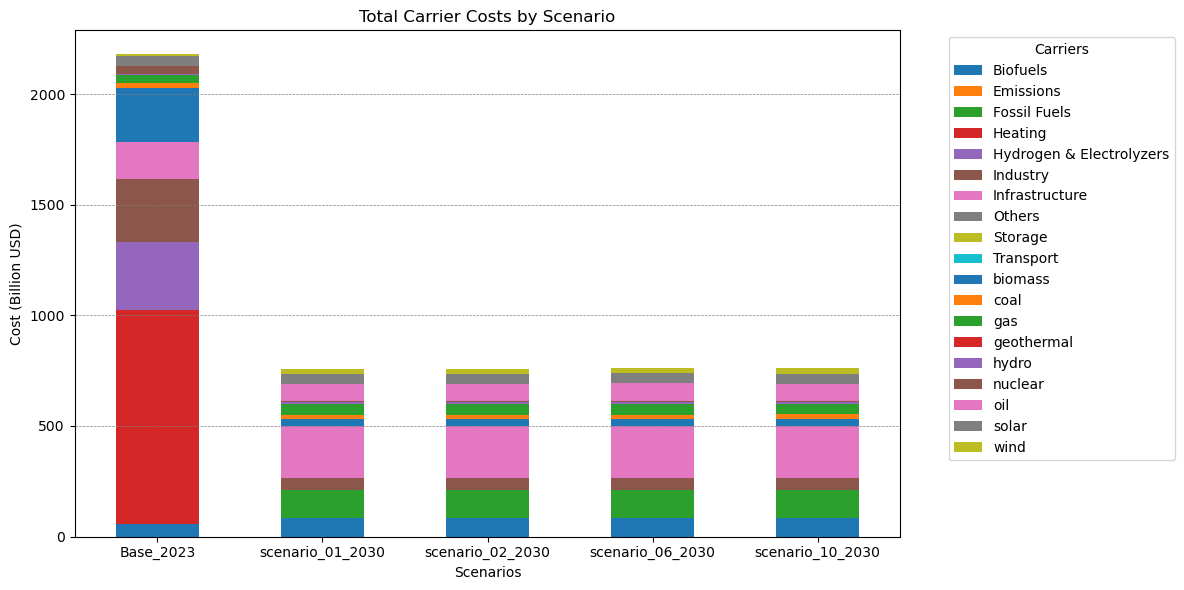

In [21]:
total_carrier_costs.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Total Carrier Costs by Scenario")
plt.ylabel("Cost (Billion USD)")
plt.xlabel("Scenarios")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
plt.legend(title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [22]:
total_carrier_costs

Base_2023  scenario_01_2030  scenario_02_2030  \
carrier                                                                    
Biofuels                   57.048127         85.141607         85.141607   
Emissions                  -0.010124         -0.033874         -0.033887   
Fossil Fuels                0.021167        123.256213        123.349276   
Heating                   964.985421          0.095033          0.095090   
Hydrogen & Electrolyzers  308.235679          3.473762          3.695605   
Industry                  283.942608         50.894315         50.916574   
Infrastructure            167.913644        234.834131        234.789257   
Others                     -0.000147         -0.000164         -0.000079   
Storage                     1.998157          0.000010          0.000042   
Transport                   0.053394          0.014651          0.014803   
biomass                   241.160152         32.170142         32.169944   
coal                       25.275919         20.818568         20.824316   
gas                        33.289648         47.827327         47.867619   
geothermal                  0.606454          0.568272          0.568273   
hydro                       5.660658          8.562641          8.562641   
nuclear                    36.459636          5.906911          5.907093   
oil                         0.415305         76.421550         76.189994   
solar                      42.938552         42.862611         42.906649   
wind                        8.866310         25.956792         26.074742   

                          scenario_06_2030  scenario_10_2030  
carrier                                                       
Biofuels                         85.141812         85.141607  
Emissions                        -0.034236         -0.033891  
Fossil Fuels                    123.393339        123.379127  
Heating                           0.093649          0.095186  
Hydrogen & Electrolyzers          3.694950          3.695736  
Industry                         51.601540         51.602787  
Infrastructure                  233.849213        234.787955  
Others                           -0.000173         -0.000136  
Storage                           0.000122          0.000043  
Transport                         0.014507          0.014859  
biomass                          32.176083         32.169906  
coal                             20.906567         20.824413  
gas                              47.625757         47.880696  
geothermal                        0.568279          0.568274  
hydro                             8.562600          8.562641  
nuclear                           5.907969          5.907107  
oil                              81.025106         76.189986  
solar                            42.859003         42.917300  
wind                             25.370313         26.085950

In [23]:
total_carrier_costs.sum(axis=0)

Base_2023           2178.860559
scenario_01_2030     758.770498
scenario_02_2030     759.039560
scenario_06_2030     762.756401
scenario_10_2030     759.789546
dtype: float64

---

## 4. Capacity Analysis: What Was Built?

*Here, we analyze the optimal installed capacities of generation, storage, and conversion technologies as determined by the model.*

### 4.1. Map: Total Installed Electricity Capacity
*A map showing the total installed capacity (in GW) for each electricity generation carrier (e.g., Solar, Onshore Wind, Offshore Wind) at different locations.*

Plotting network: Base_2023


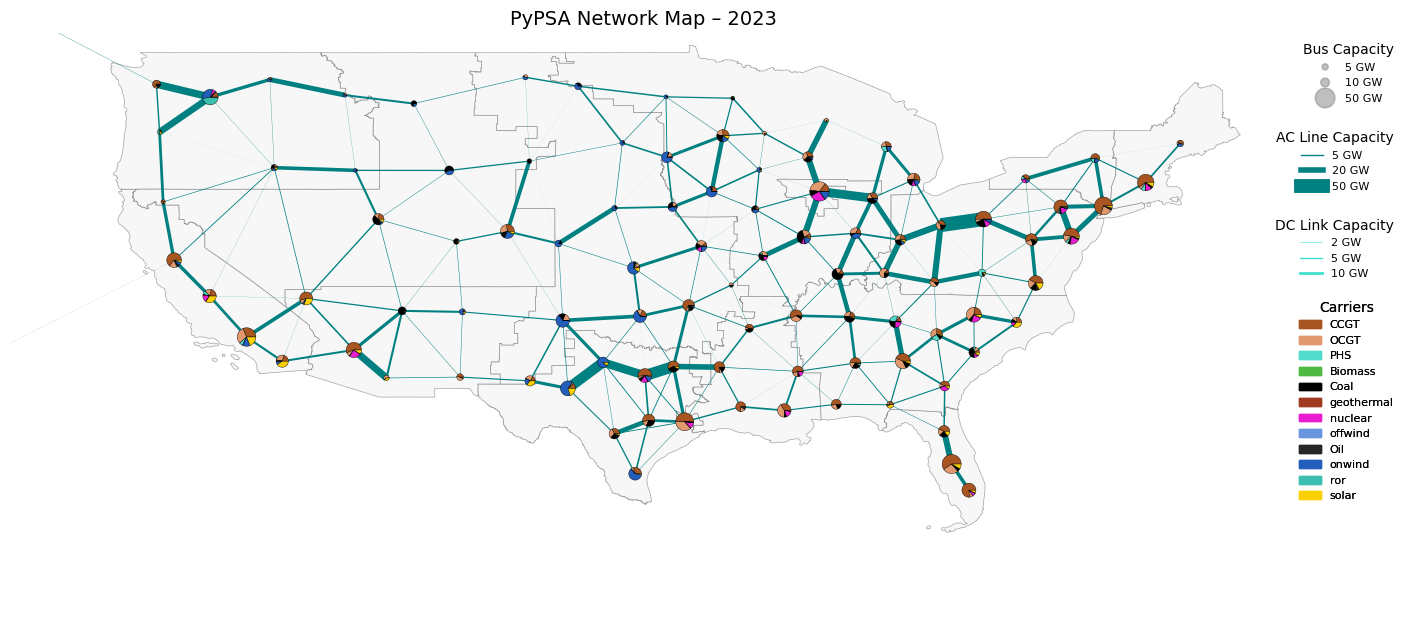

Plotting network: scenario_01_2030


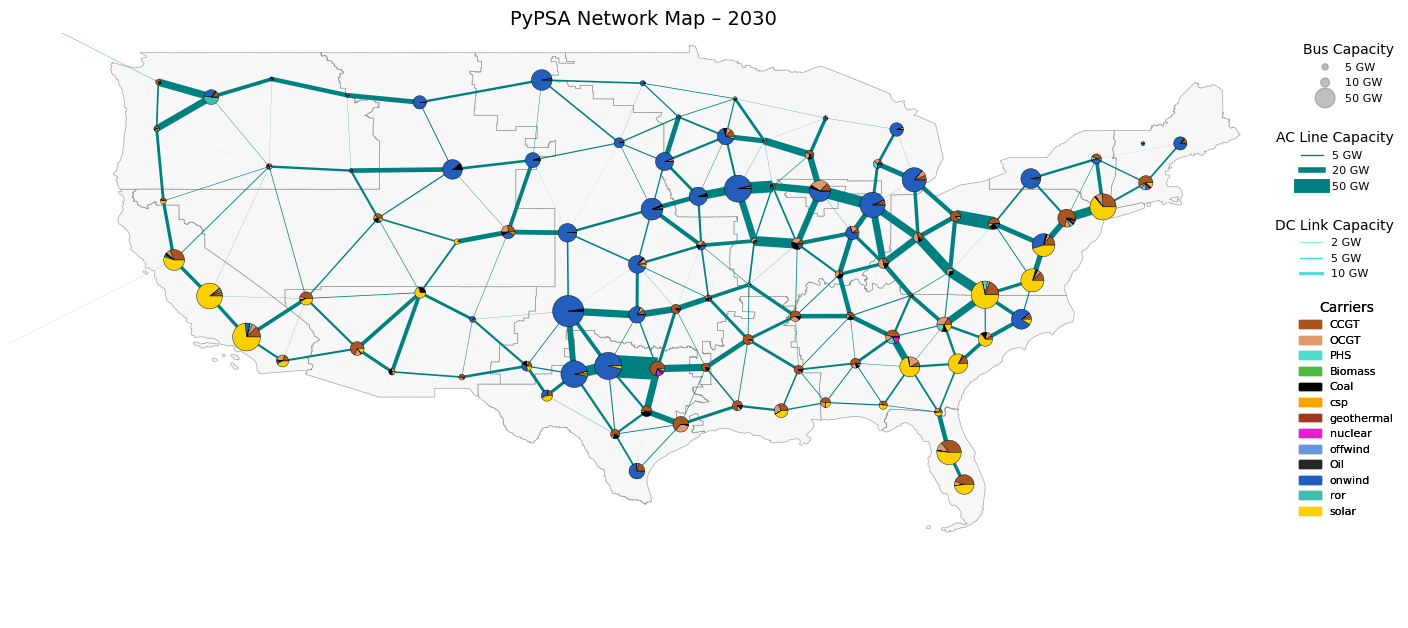

Plotting network: scenario_02_2030


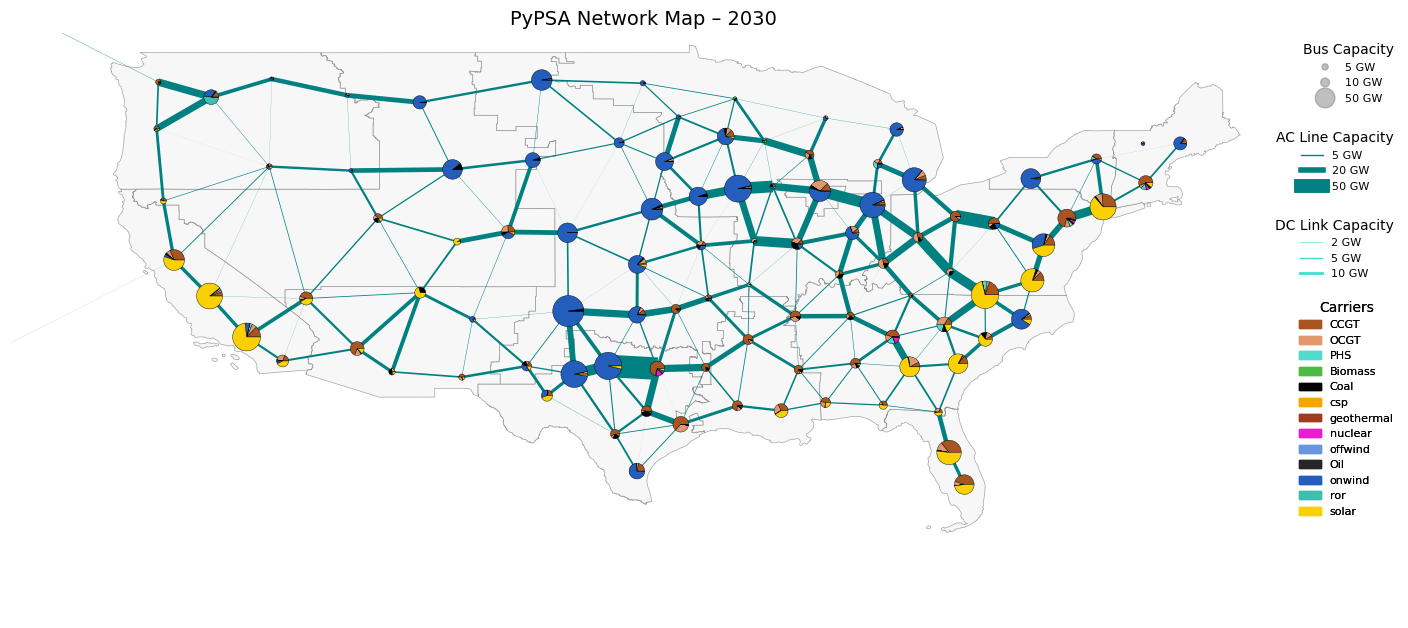

Plotting network: scenario_06_2030


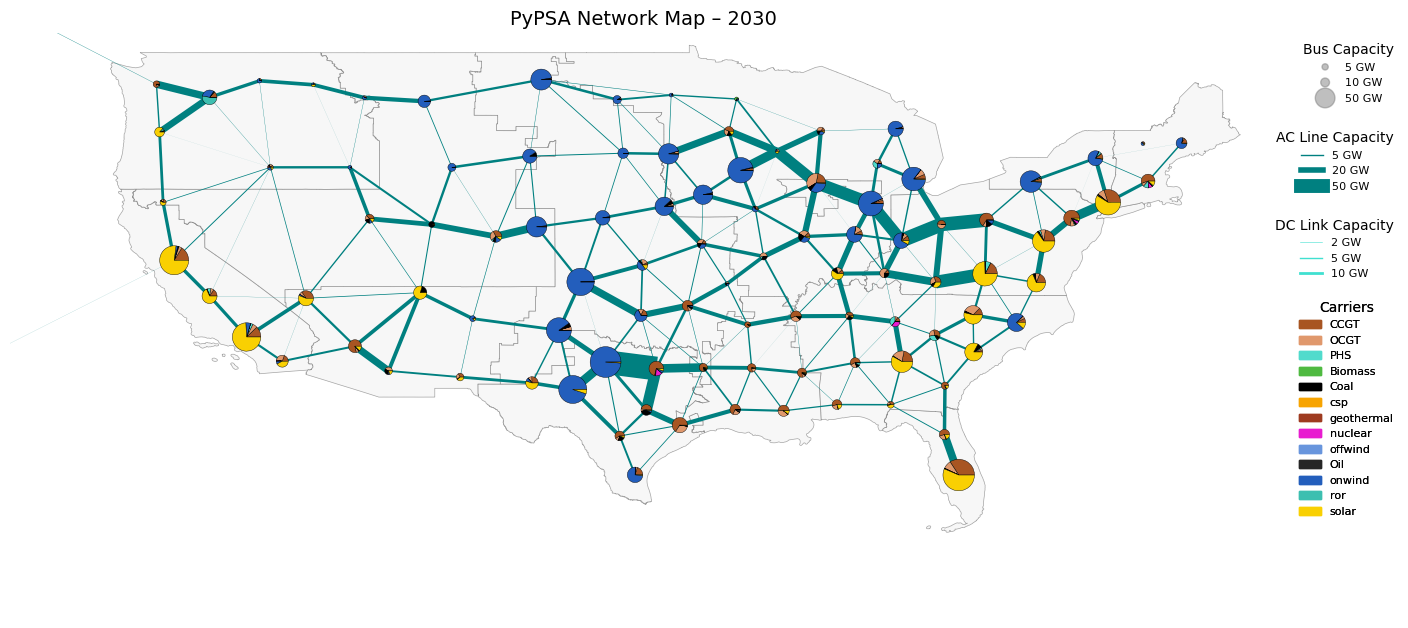

Plotting network: scenario_10_2030


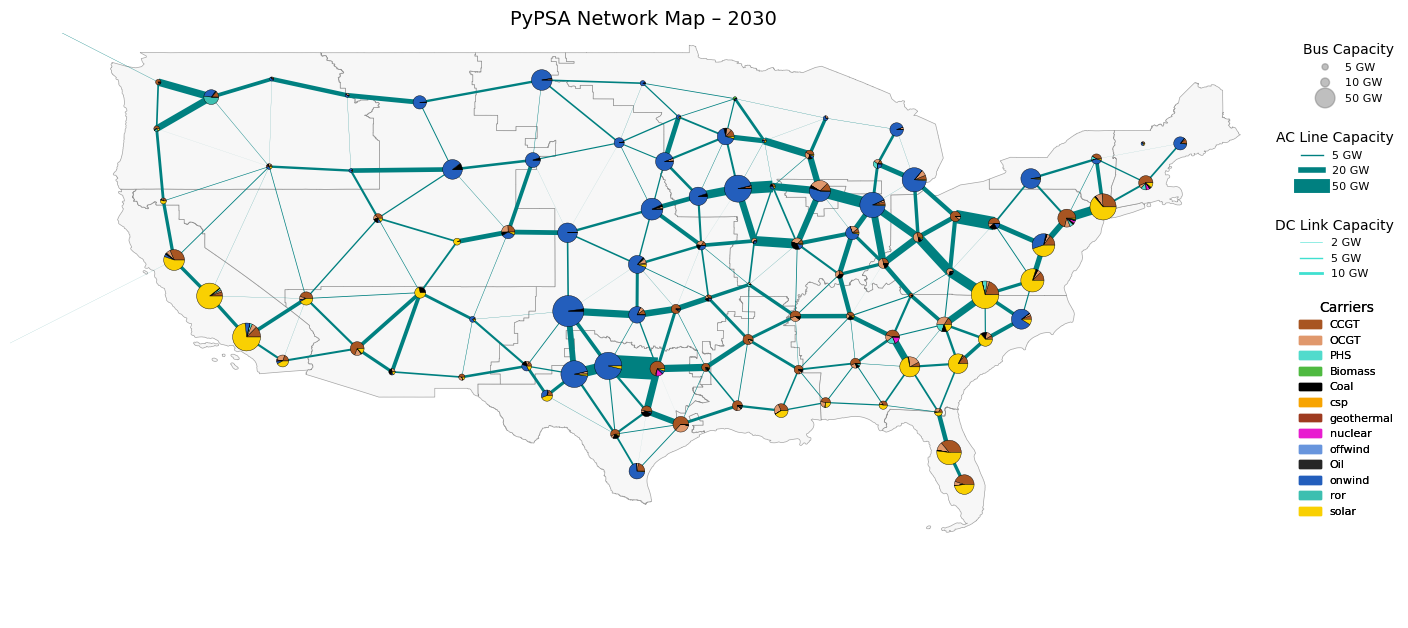

In [24]:
for key, n in networks.items():
    print(f"Plotting network: {key}")
    
    fill_missing_color(n, tech_colors)
    fill_missing_nice_names(n, nice_names)
    update_ac_dc_bus_coordinates(n)
    
    # Electricity generators (or links, using efficiency to scale them)
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }
    
    gen_p_nom_opt = n.generators[n.generators.carrier.isin(gen_carriers)]
    gen_p_nom_opt = gen_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    sto_p_nom_opt = n.storage_units[n.storage_units.carrier.isin(gen_carriers)]
    sto_p_nom_opt = sto_p_nom_opt.groupby(["bus", "carrier"]).p_nom_opt.sum()
    
    link_mask = (
        n.links.efficiency.notnull()
        & (n.links.p_nom_opt > 0)
        & n.links.carrier.isin(link_carriers)
    )
    electricity_links = n.links[link_mask].copy()
    electricity_links["electric_output"] = electricity_links.p_nom_opt * electricity_links.efficiency
    link_p_nom_opt = electricity_links.groupby(["bus1", "carrier"]).electric_output.sum()
    link_p_nom_opt.index = link_p_nom_opt.index.set_names(["bus", "carrier"])
    
    # Join all contributors to electricity generators
    bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt, link_p_nom_opt])
    bus_carrier_capacity = bus_carrier_capacity.groupby(level=[0, 1]).sum()
    bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]
    
    # Valid coordinates for buses
    valid_buses = n.buses.dropna(subset=["x", "y"])
    valid_buses = valid_buses[
        (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
        (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
    ]
    
    # Merge offwind-ac and offwind-dc into a single 'offwind' category
    bus_carrier_capacity = bus_carrier_capacity.reset_index()
    bus_carrier_capacity['carrier'] = bus_carrier_capacity['carrier'].replace({
        'offwind-ac': 'offwind',
        'offwind-dc': 'offwind'
    })
    bus_carrier_capacity = bus_carrier_capacity.groupby(['bus', 'carrier'], as_index=False).sum()
    bus_carrier_capacity = bus_carrier_capacity.set_index(['bus', 'carrier']).squeeze()

    # Capacity per bus and carrier
    capacity_df = bus_carrier_capacity.unstack(fill_value=0)
    capacity_df = capacity_df.loc[capacity_df.index.intersection(valid_buses.index)]
    
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
    
    # Setup Map
    regions_onshore_clipped.plot(
        ax=ax,
        facecolor='whitesmoke',
        edgecolor='gray',
        alpha=0.7,
        linewidth=0.5,
        zorder=0,
    )

    # Salva i link originali
    original_links = n.links.copy()
    
    # Filtra i link elettrici in modo sicuro
    n.links = n.links[n.links.index.isin(electricity_links.index)]
    
    # Plot della rete con link filtrati
    line_scale = 5e3
    n.plot(
        ax=ax,
        bus_sizes=0,
        bus_alpha=0,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors='teal',
        link_colors='turquoise',
        color_geomap=False,
        flow=None,
    )
    
    # Ripristina i link originali
    n.links = original_links

    # Pie chart for capacities
    pie_scale = 0.003
    for bus_id, capacities in capacity_df.iterrows():
        x, y = valid_buses.loc[bus_id, ['x', 'y']]
        if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
            continue
    
        values = capacities.values
        total = values.sum()
        if total == 0:
            continue
    
        size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
        colors = [tech_colors.get(c, 'gray') for c in capacities.index]
    
        start_angle = 0
        for val, color in zip(values, colors):
            if val == 0:
                continue
            angle = 360 * val / total  # proporzione rispetto al totale del nodo
            wedge = Wedge(
                center=(x, y),
                r=size,
                theta1=start_angle,
                theta2=start_angle + angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.3,
                transform=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=5,
            )
            ax.add_patch(wedge)
            start_angle += angle
            
    class HandlerCircle(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            center = (width / 2, height / 2)
            radius = orig_handle.get_radius()
            p = plt.Circle(center, radius)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]
    
    # Legends
    bus_caps = [5, 10, 50]
    bus_patches = []
    for cap in bus_caps:
        r_in_map = np.sqrt(cap)
        r_pts = r_in_map * fig.dpi * 2
        circ = plt.Circle((0, 0), radius=r_pts / 2 / fig.dpi, color='gray', alpha=0.5)
        bus_patches.append(circ)
    
    bus_legend = ax.legend(
        bus_patches,
        [f"{cap} GW" for cap in bus_caps],
        title="Bus Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        handler_map={mpatches.Circle: HandlerCircle()},
        loc='upper right',
        bbox_to_anchor=(1.1, 1.0)
    )
    
    ac_caps = [5e3, 20e3, 50e3]
    ac_patches = [
        mlines.Line2D([], [], color='teal', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in ac_caps
    ]
    ac_legend = ax.legend(
        handles=ac_patches,
        title="AC Line Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.85)
    )
    
    dc_caps = [2e3, 5e3, 10e3]
    dc_patches = [
        mlines.Line2D([], [], color='turquoise', linewidth=cap / line_scale, label=f"{int(cap/1e3)} GW")
        for cap in dc_caps
    ]
    dc_legend = ax.legend(
        handles=dc_patches,
        title="DC Link Capacity",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.70)
    )
    
    carrier_handles = [
        mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
        for c in sorted(capacity_df.columns) if capacity_df[c].sum() > 0
    ]
    carrier_legend = ax.legend(
        handles=carrier_handles,
        title="Carriers",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.1, 0.56),
        ncol=1
    )
    
    ax.add_artist(bus_legend)
    ax.add_artist(ac_legend)
    ax.add_artist(dc_legend)
    ax.add_artist(carrier_legend)
        
    ax.set_extent([-130, -65, 20, 50], crs=ccrs.PlateCarree())
    ax.autoscale(False)
    
    year = key[-4:]  # Extract the year
    ax.set_title(f"PyPSA Network Map – {year}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [25]:
totals_by_carrier = {}

for name, net in networks.items():
    # Define carriers used in the plot
    gen_carriers = {
        "onwind", "offwind-ac", "offwind-dc", "solar", "solar-rooftop",
        "csp", "nuclear", "geothermal", "ror", "PHS", "Reservoir & Dam"
    }
    link_carriers = {
        "OCGT", "CCGT", "coal", "oil", "biomass", "biomass CHP", "gas CHP"
    }

    # Generators
    gen = net.generators.copy()
    gen['carrier'] = gen['carrier'].replace({'offwind-ac': 'offwind', 'offwind-dc': 'offwind'})
    gen = gen[gen.carrier.isin(gen_carriers)]
    gen_totals = gen.groupby('carrier')['p_nom_opt'].sum()

    # Storage
    sto = net.storage_units.copy()
    sto = sto[sto.carrier.isin(gen_carriers)]
    sto_totals = sto.groupby('carrier')['p_nom_opt'].sum()

    # Links (output side scaled by efficiency)
    links = net.links.copy()
    mask = (
        links.efficiency.notnull()
        & (links.p_nom_opt > 0)
        & links.carrier.isin(link_carriers)
    )
    links = links[mask]
    links_totals = links.groupby('carrier').apply(
        lambda df: (df['p_nom_opt'] * df['efficiency']).sum()
    )

    # Combine all
    all_totals = pd.concat([gen_totals, sto_totals, links_totals])
    all_totals = all_totals.groupby(all_totals.index).sum()  # Merge duplicates
    all_totals = all_totals[all_totals > 0]
    totals_by_carrier[name] = all_totals

# Build dataframe
carrier_capacity_df = pd.DataFrame(totals_by_carrier).fillna(0)

# Convert MW → GW
carrier_capacity_df = carrier_capacity_df / 1000
carrier_capacity_df = carrier_capacity_df.round(2)

# Filter: only keep rows with at least one nonzero value
carrier_capacity_df = carrier_capacity_df.loc[carrier_capacity_df.sum(axis=1) > 0]

# Add label
carrier_capacity_df.index.name = "carrier (GW)"

# Display
from IPython.display import display
display(carrier_capacity_df)


Base_2023  scenario_01_2030  scenario_02_2030  scenario_06_2030  \
carrier (GW)                                                                    
CCGT             300.00            287.39            287.61            285.53   
OCGT             167.94            137.61            137.61            137.60   
PHS               21.98             21.98             21.98             21.98   
biomass            3.07              2.22              2.22              2.22   
coal             109.89             43.44             43.44             43.43   
geothermal         1.29              1.19              1.19              1.19   
nuclear           52.40              7.35              7.35              7.35   
oil                8.04              3.41              3.41              3.42   
onwind           132.76            722.74            726.26            720.60   
ror                9.87              9.60              9.60              9.60   
solar             60.39            375.34            376.90            375.94   

              scenario_10_2030  
carrier (GW)                    
CCGT                    287.68  
OCGT                    137.61  
PHS                      21.98  
biomass                   2.22  
coal                     43.44  
geothermal                1.19  
nuclear                   7.35  
oil                       3.41  
onwind                  726.57  
ror                       9.60  
solar                   377.14

### 4.2. Map: Total Installed Hydrogen Electrolyzer Capacity
*This map visualizes the spatial distribution and total capacity (in GW) of different electrolyzer technologies (e.g., AEL, PEM).*

In [26]:


def plot_h2_capacities_map(network, title):
    """
    Plot the H2 capacities on a map.
    """
    
    h2_carriers_links = ['H2 pipeline repurposed', 'H2 pipeline']
    h2_carriers_buses = ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC',]
    
    net = network.copy()
    assign_location(net)

    h2_capacity_data = compute_h2_capacities(net)[h2_carriers_buses]

    net.links.query("carrier in @h2_carriers_links", inplace=True)
    valid_buses = net.buses.dropna(subset=["x", "y"])
    valid_buses = valid_buses[
        (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
        (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
    ]

    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
    regions_onshore_clipped.plot(
            ax=ax,
            facecolor='whitesmoke',
            edgecolor='gray',
            alpha=0.7,
            linewidth=0.5,
            zorder=0,
        )

    line_scale = 5e-3
    net.plot(
            ax=ax,
            bus_sizes=0,
            bus_alpha=0,
            # link_widths=net.links.p_nom_opt / line_scale,
            line_colors='teal',
            link_colors='turquoise',
            color_geomap=False,
            flow=None,
            branch_components=['Link'],
            boundaries=[-130, -60, 20, 50],  # view showing
        )
    pie_scale = 1

    for bus_id, capacities in h2_capacity_data.iterrows():
        x, y = valid_buses.loc[bus_id, ['x', 'y']]
        if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
            continue

        values = capacities.values
        total = values.sum()
        if total == 0:
            continue

        size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
        colors = [tech_colors.get(c, 'gray') for c in capacities.index]
        
        start_angle = 0
        for val, color in zip(values, colors):
            if val == 0:
                continue
            angle = 360 * val / total  # proporzione rispetto al totale del nodo
            wedge = Wedge(
                center=(x, y),
                r=size * 0.5,
                theta1=start_angle,
                theta2=start_angle + angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.3,
                transform=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=5,
            )
            ax.add_patch(wedge)
            start_angle += angle
            # ax.annotate(f'{total:.02f} kW', 
            #            xy=(x, y - size - 0.3), 
            #            ha='center', va='top', fontsize=5, fontweight='bold')

    class HandlerCircle(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                            xdescent, ydescent, width, height, fontsize, trans):
            center = (width / 2, height / 2)
            radius = orig_handle.get_radius()
            p = plt.Circle(center, radius)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]

    # Legends
    bus_caps = [0.1, 0.5, 1]
    bus_patches = []
    for cap in bus_caps:
        r_in_map = np.sqrt(cap)
        r_pts = r_in_map * fig.dpi * 2
        circ = plt.Circle((0, 0), radius=r_pts / 0.2 / fig.dpi, color='gray', alpha=0.5)
        bus_patches.append(circ)

    bus_legend = ax.legend(
        bus_patches,
        [f"{cap} kW" for cap in bus_caps],
        title="Bus Capacity",
        title_fontsize=10,
        fontsize=10,
        frameon=False,
        handler_map={mpatches.Circle: HandlerCircle()},
        loc='upper right',
        bbox_to_anchor=(1.05, 0.95),
        labelspacing=0.9,
    )

    link_caps = [0.1, 0.5, 1]
    # link_scale = 12
    link_patches = [
        mlines.Line2D([], [], color='turquoise', linewidth=cap, label=f"{cap} kW")
        for cap in link_caps
    ]
    link_legend = ax.legend(
        handles=link_patches,
        title="H2 Pipeline",
        title_fontsize=10,
        fontsize=8,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.05, 0.70)
    )

    carrier_handles = [
            mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
            for c in sorted(h2_capacity_data.columns) if h2_capacity_data[c].sum() > 0
        ]
    carrier_legend = ax.legend(
        handles=carrier_handles,
        title="Carriers",
        title_fontsize=10,
        fontsize=10,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.05, 0.55),
        ncol=1,
        labelspacing=0.9,
    )

    ax.add_artist(bus_legend)
    ax.add_artist(link_legend)
    ax.add_artist(carrier_legend)

    ax.set_extent([-130, -60, 20, 50], crs=ccrs.PlateCarree())
    ax.autoscale(False)

    ax.set_title(f'Installed Hydrogen Electrolyzer Capacity for {title}', 
                fontsize=12, fontweight='bold', pad=30)
        
    plt.tight_layout()
    plt.show()


Plotting H2 capacities for Base_2023...


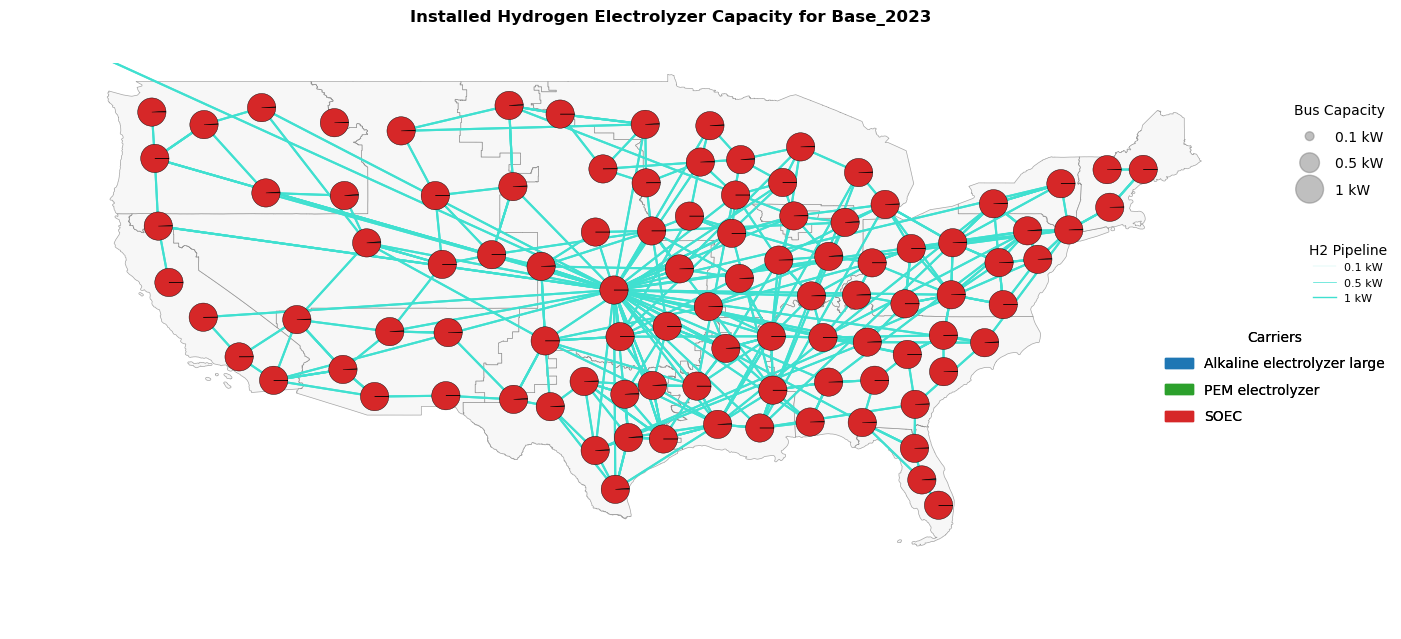

Plotting H2 capacities for scenario_01_2030...


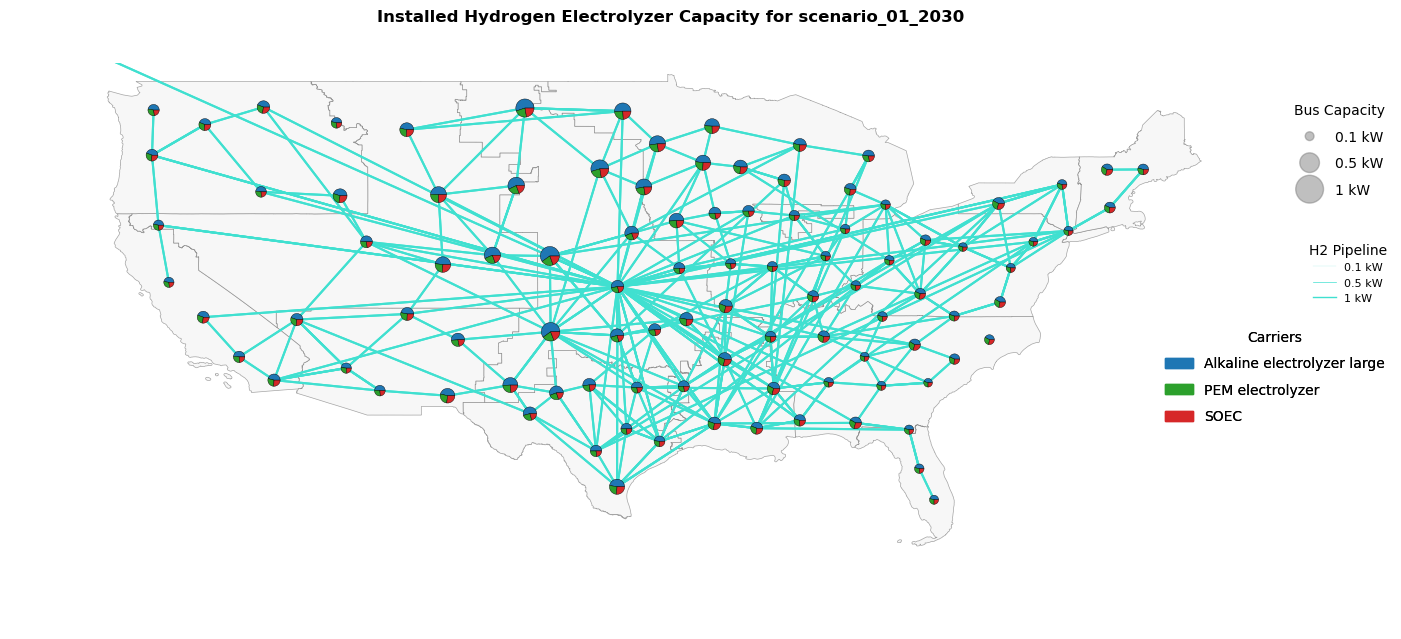

Plotting H2 capacities for scenario_02_2030...


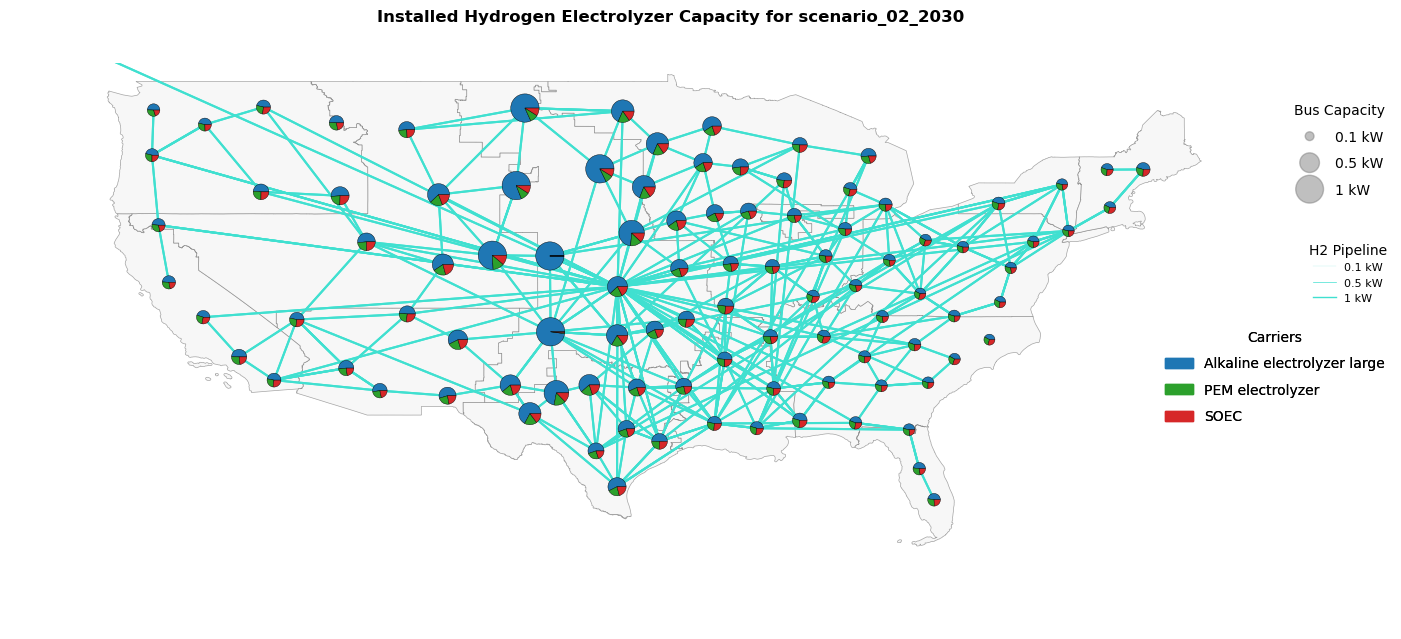

Plotting H2 capacities for scenario_06_2030...


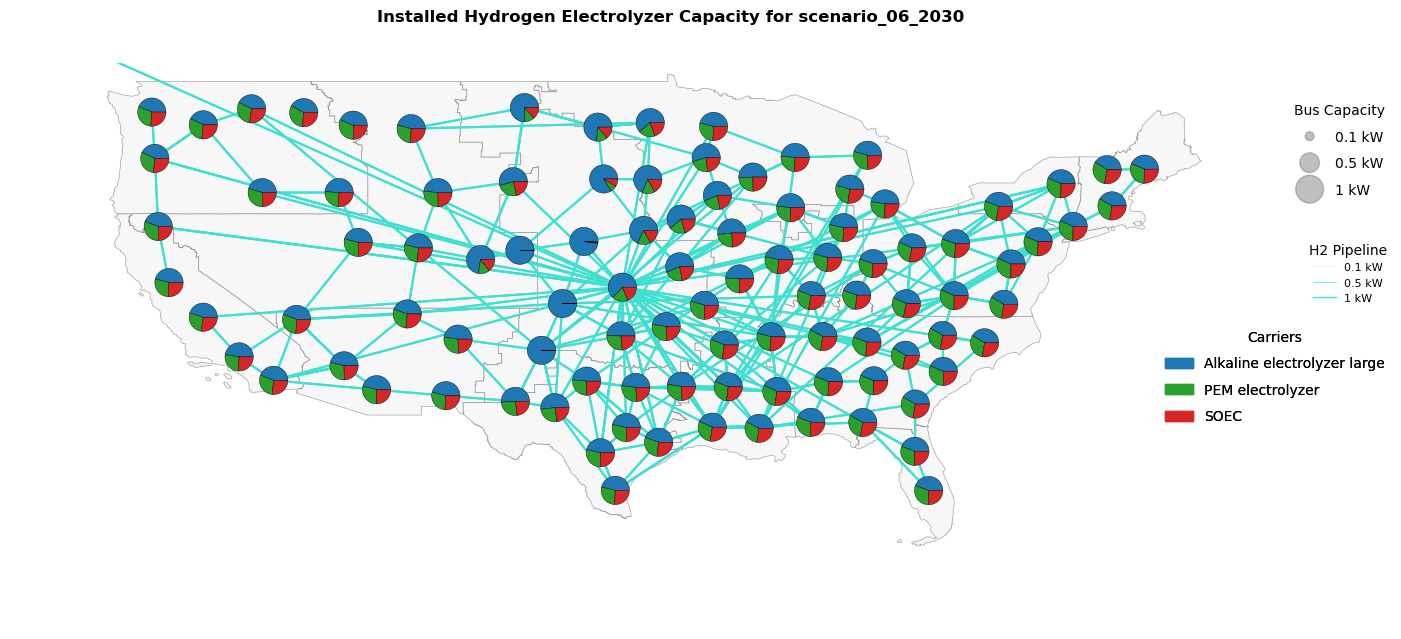

Plotting H2 capacities for scenario_10_2030...


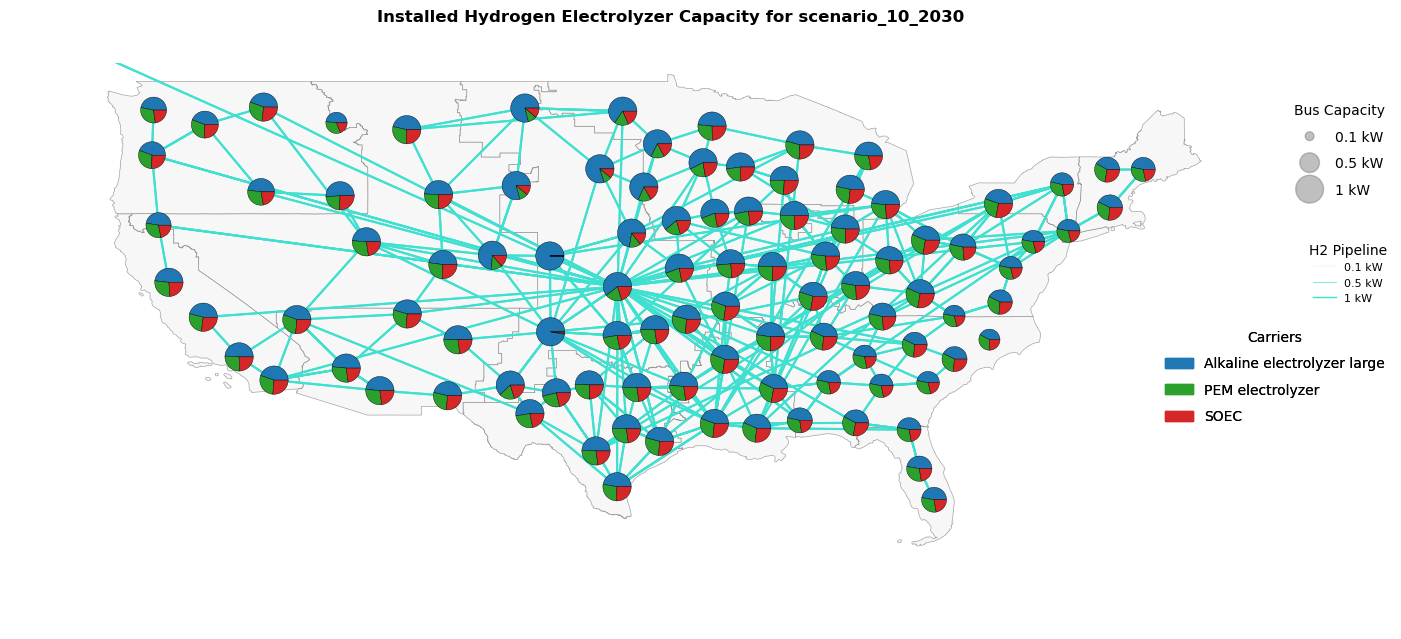

In [27]:
for idx, network in enumerate(networks.keys()):
    print(f"Plotting H2 capacities for {network}...")
    plot_h2_capacities_map(networks[network], network)

Plotting H2 capacities bar chart for Base_2023...


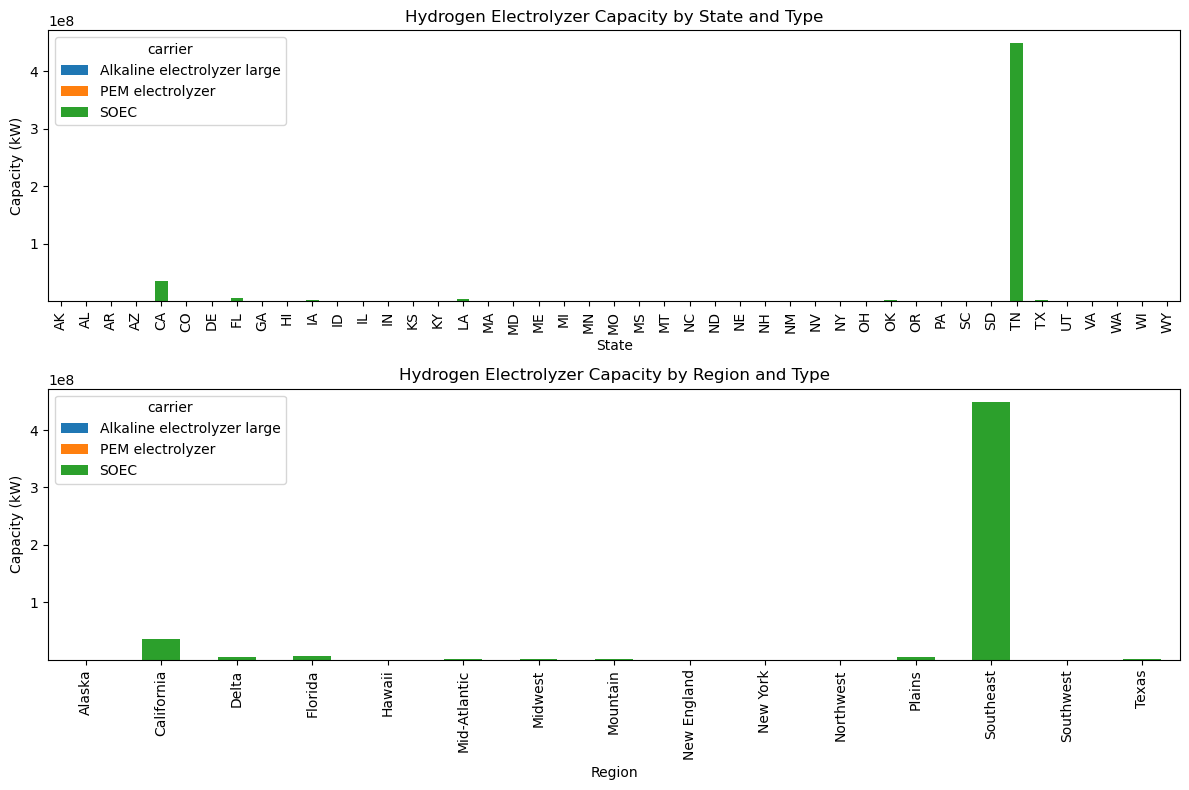

Plotting H2 capacities bar chart for scenario_01_2030...


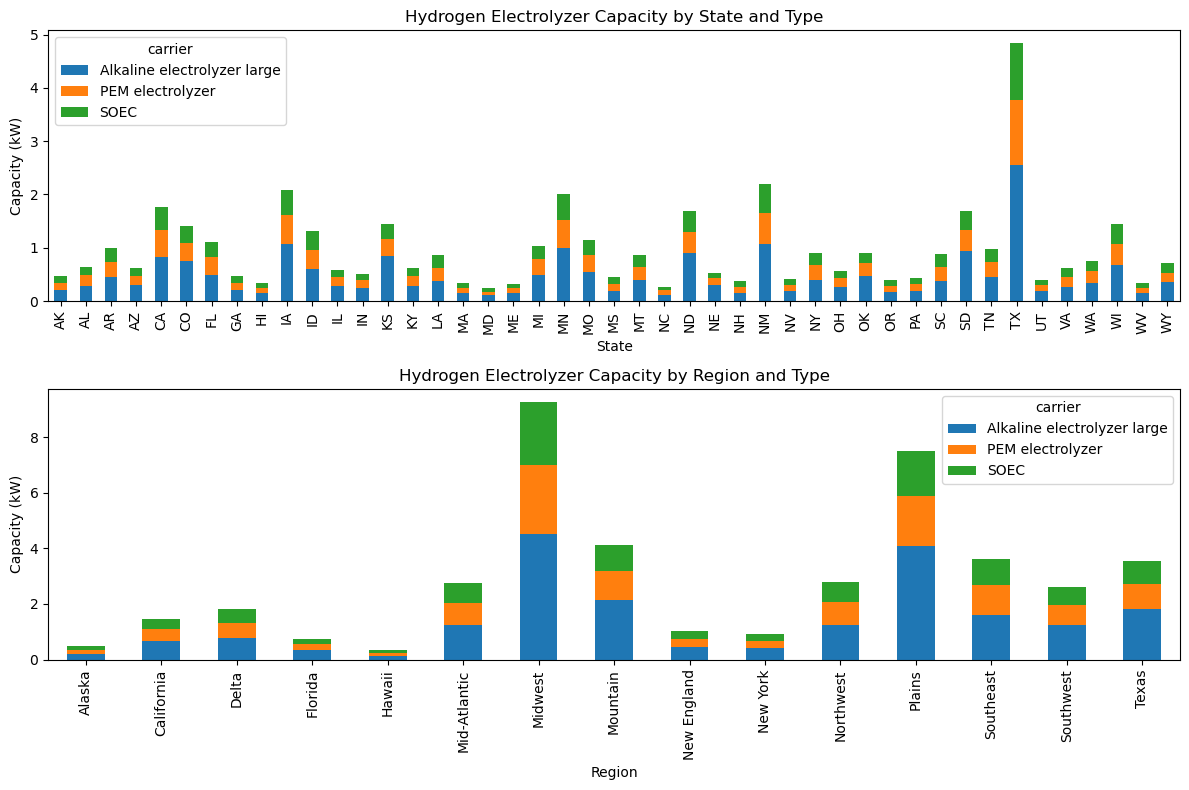

Plotting H2 capacities bar chart for scenario_02_2030...


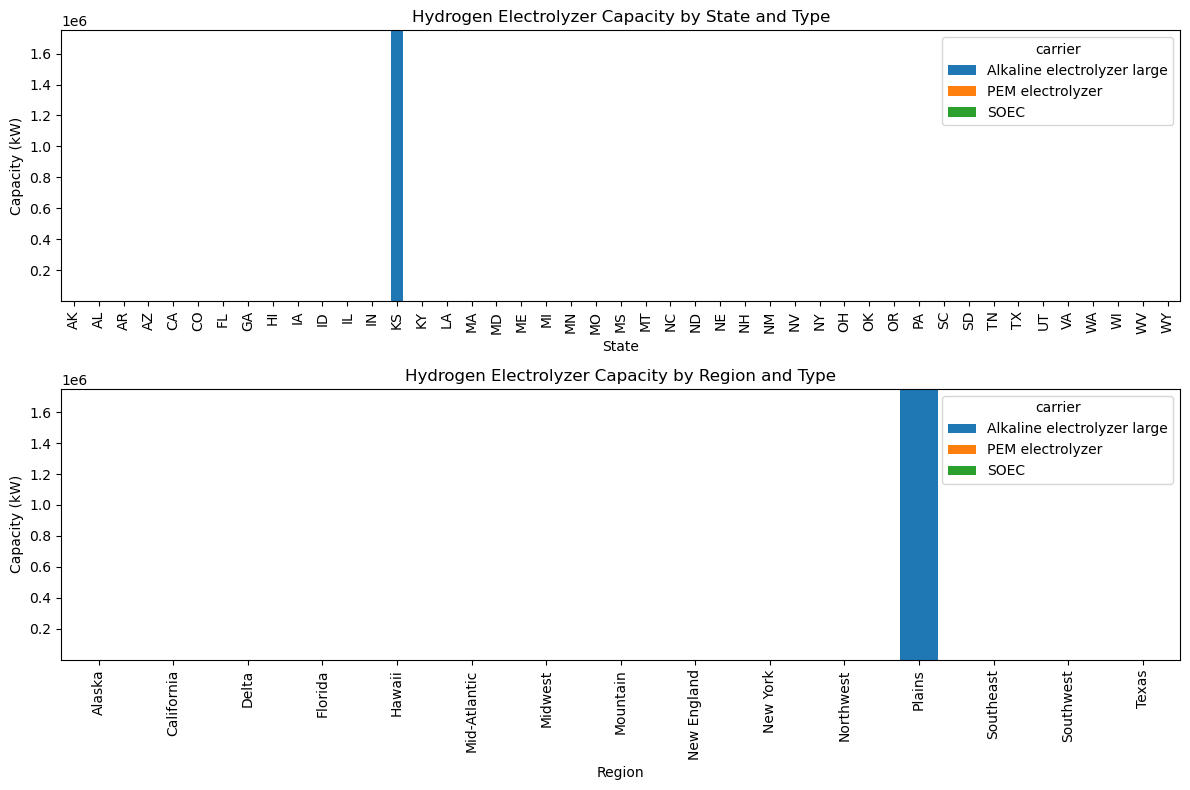

Plotting H2 capacities bar chart for scenario_06_2030...


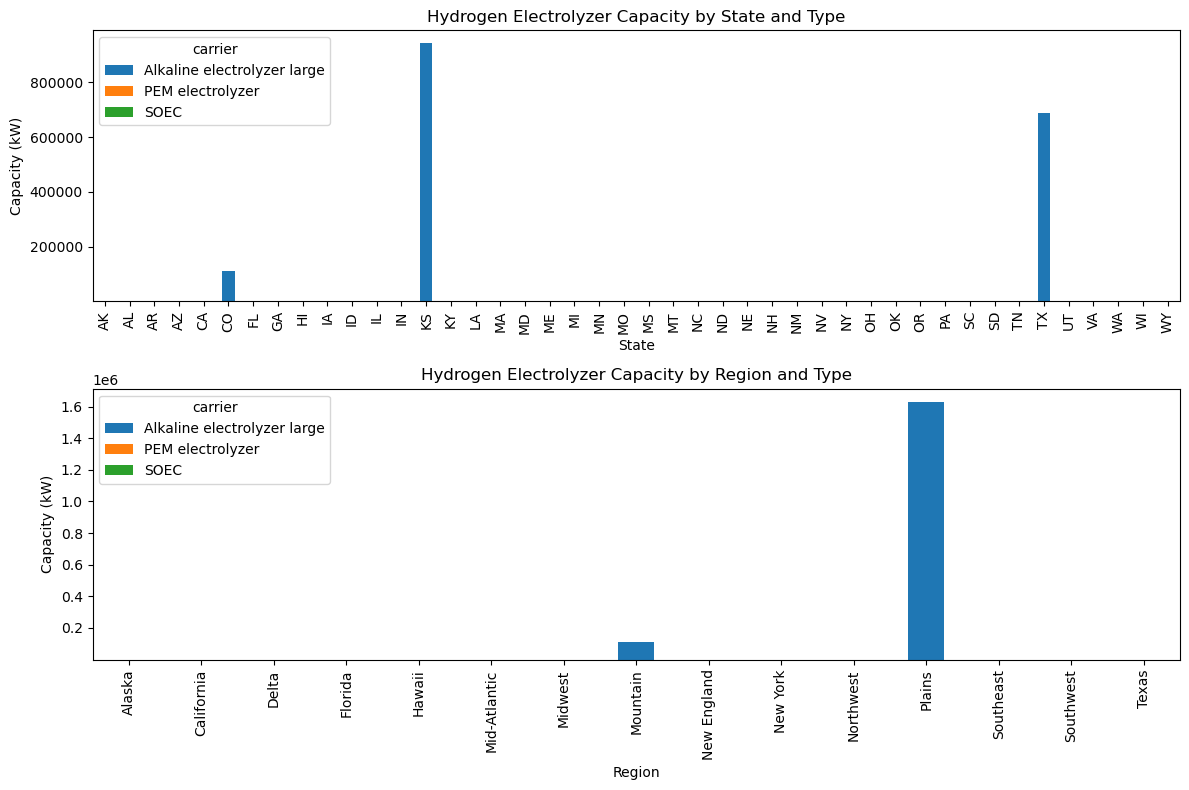

Plotting H2 capacities bar chart for scenario_10_2030...


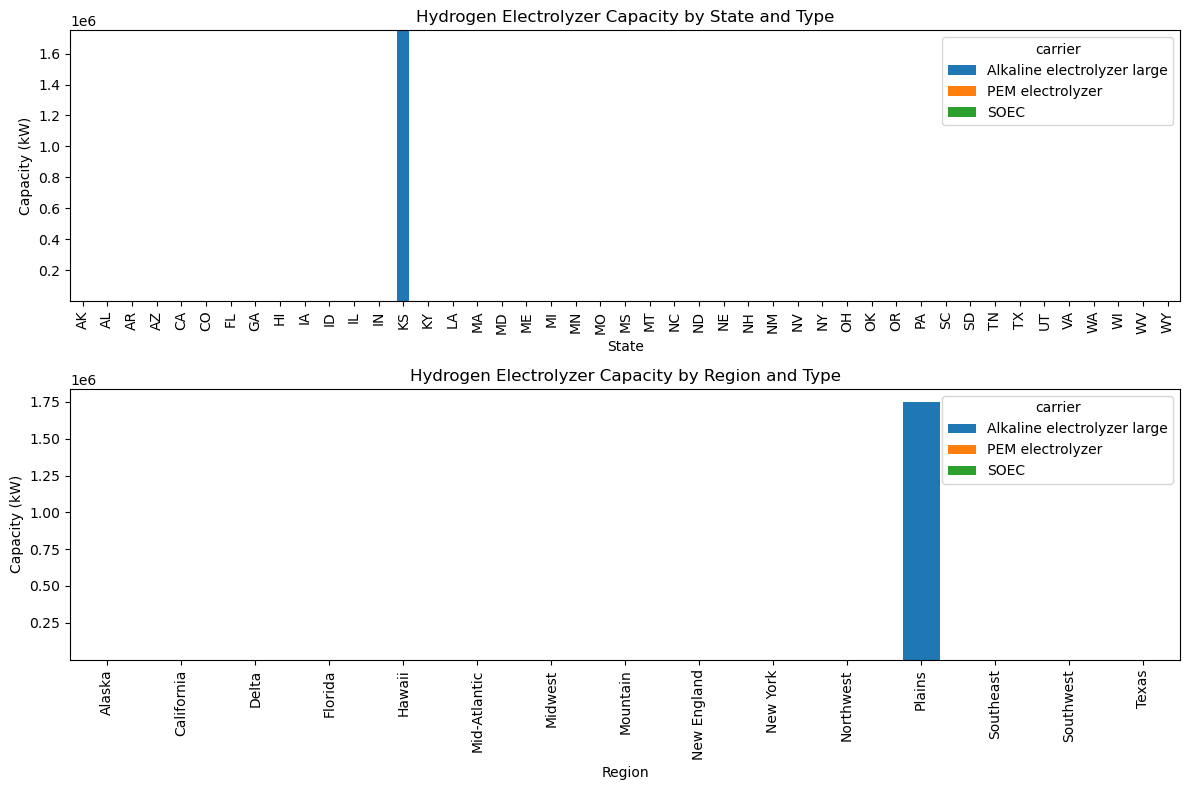

In [28]:
for idx, network in enumerate(networks.keys()):
    print(f"Plotting H2 capacities bar chart for {network}...")
    plot_h2_capacities_bar(networks[network])


In [29]:
for idx, network in enumerate(networks.keys()):
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['state'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().round(2)
    print(f"Hydrogen capacities for {network}:")
    from IPython.display import display
    display(h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T)

Hydrogen capacities for Base_2023:


state                                TX           CA       MN          FL  \
carrier                                                                     
Alkaline electrolyzer large       78.37        44.39    33.43       27.29   
PEM electrolyzer                  32.92        18.33    14.11       11.52   
SOEC                         1269834.04  35999181.21  6352.34  5761147.84   

state                                  TN       MO        NY          IA  \
carrier                                                                    
Alkaline electrolyzer large  2.695000e+01    26.91     26.82       26.73   
PEM electrolyzer             1.123000e+01    11.22     11.14       11.25   
SOEC                         4.488506e+08  5444.31  29883.33  1329260.01   

state                             NM          LA  ...       ME      AK  \
carrier                                           ...                    
Alkaline electrolyzer large    26.25       26.16  ...     8.96    8.54   
PEM electrolyzer               11.11       10.95  ...     3.82    3.60   
SOEC                         7028.09  4521206.74  ...  6477.38  640.84   

state                               WY         MS        OR       NV       MA  \
carrier                                                                         
Alkaline electrolyzer large       8.41       8.40      8.18     8.17     8.15   
PEM electrolyzer                  3.53       3.53      3.36     3.44     3.39   
SOEC                         174492.97  422579.35  84289.69  1511.50  2245.02   

state                            AR       NH       HI  
carrier                                                
Alkaline electrolyzer large    8.10     7.94     7.04  
PEM electrolyzer               3.39     3.47     3.46  
SOEC                         970.47  1936.04  1553.79  

[3 rows x 45 columns]

Hydrogen capacities for scenario_01_2030:


state                          TX    IA    NM    MN    SD    ND    KS    CA  \
carrier                                                                       
Alkaline electrolyzer large  2.55  1.08  1.07  1.00  0.94  0.90  0.84  0.82   
PEM electrolyzer             1.21  0.54  0.59  0.51  0.39  0.40  0.32  0.51   
SOEC                         1.07  0.47  0.54  0.49  0.35  0.39  0.29  0.44   

state                          CO    WI  ...    PA    NV    OR    NH    ME  \
carrier                                  ...                                 
Alkaline electrolyzer large  0.74  0.68  ...  0.19  0.19  0.17  0.15  0.15   
PEM electrolyzer             0.35  0.40  ...  0.13  0.12  0.11  0.11  0.10   
SOEC                         0.32  0.37  ...  0.11  0.11  0.10  0.11  0.08   

state                          HI    MA    WV    NC    MD  
carrier                                                    
Alkaline electrolyzer large  0.14  0.14  0.14  0.11  0.11  
PEM electrolyzer             0.10  0.10  0.10  0.08  0.07  
SOEC                         0.10  0.09  0.09  0.07  0.06  

[3 rows x 45 columns]

Hydrogen capacities for scenario_02_2030:


state                                KS     TX    SD    ND    CO    IA    NM  \
carrier                                                                        
Alkaline electrolyzer large  1750652.59  34.70  5.45  3.46  2.56  2.54  2.14   
PEM electrolyzer                   0.52   2.13  0.63  0.52  0.56  0.81  0.82   
SOEC                               0.51   2.00  0.60  0.49  0.53  0.75  0.84   

state                          MN    OK    NE  ...    AK    MS    ME    OR  \
carrier                                        ...                           
Alkaline electrolyzer large  2.11  1.35  1.35  ...  0.28  0.25  0.24  0.22   
PEM electrolyzer             0.63  0.44  0.26  ...  0.16  0.15  0.15  0.14   
SOEC                         0.60  0.36  0.22  ...  0.15  0.14  0.14  0.12   

state                          HI    NH    MA    MD    WV    NC  
carrier                                                          
Alkaline electrolyzer large  0.20  0.18  0.17  0.17  0.15  0.14  
PEM electrolyzer             0.13  0.12  0.11  0.11  0.10  0.10  
SOEC                         0.12  0.11  0.11  0.08  0.11  0.10  

[3 rows x 45 columns]

Hydrogen capacities for scenario_06_2030:


state                               KS         TX         CO      NE     SD  \
carrier                                                                       
Alkaline electrolyzer large  942997.18  687321.39  111101.19  716.53  78.80   
PEM electrolyzer                 12.39      29.16      16.01   12.90  10.11   
SOEC                             13.65      27.76      17.50   14.63  10.49   

state                           ND     MN     IA     MO     CA  ...    NV  \
carrier                                                         ...         
Alkaline electrolyzer large  73.39  59.21  38.09  22.09  20.19  ...  3.17   
PEM electrolyzer             11.95  18.05  13.71  10.39  12.53  ...  2.16   
SOEC                         13.18  19.18  14.48  10.07  11.59  ...  1.85   

state                          AK    MS    OR    AL    ME    MA    MD    NH  \
carrier                                                                       
Alkaline electrolyzer large  2.97  2.96  2.70  2.54  2.49  2.40  2.30  2.18   
PEM electrolyzer             2.05  2.06  1.92  1.79  1.76  1.76  1.66  1.63   
SOEC                         1.86  1.88  1.67  1.48  1.45  1.58  1.33  1.47   

state                          HI  
carrier                            
Alkaline electrolyzer large  2.03  
PEM electrolyzer             1.51  
SOEC                         1.29  

[3 rows x 44 columns]

Hydrogen capacities for scenario_10_2030:


state                                KS      TX     SD     ND     IA     MN  \
carrier                                                                       
Alkaline electrolyzer large  1750452.06  188.94  32.63  22.96  19.03  13.56   
PEM electrolyzer                   3.71    9.80   3.91   3.68   5.68   4.15   
SOEC                               4.23    9.24   4.49   4.22   6.05   4.43   

state                           CO    NE    NM    WI  ...    NV    AK    MS  \
carrier                                               ...                     
Alkaline electrolyzer large  12.48  9.86  9.85  6.47  ...  1.04  1.03  0.95   
PEM electrolyzer              2.75  1.78  4.05  3.16  ...  0.68  0.68  0.65   
SOEC                          2.92  1.97  4.05  3.29  ...  0.61  0.64  0.61   

state                          OR    MA    ME    NH    MD    HI    NC  
carrier                                                                
Alkaline electrolyzer large  0.90  0.78  0.77  0.74  0.69  0.63  0.53  
PEM electrolyzer             0.62  0.56  0.51  0.54  0.47  0.47  0.41  
SOEC                         0.52  0.48  0.35  0.49  0.31  0.39  0.31  

[3 rows x 45 columns]

In [30]:
for idx, network in enumerate(networks.keys()):
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['region'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().round(2)
    print(f"Hydrogen capacities for {network}:")
    from IPython.display import display
    display(h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T)

Hydrogen capacities for Base_2023:


region                          Midwest     Southeast      Plains  \
carrier                                                             
Alkaline electrolyzer large      156.02  1.052700e+02      104.09   
PEM electrolyzer                  65.40  4.421000e+01       43.73   
SOEC                         1653002.81  4.495236e+08  4516614.11   

region                       Mid-Atlantic      Texas   Mountain  Northwest  \
carrier                                                                      
Alkaline electrolyzer large         96.41      70.05      62.11      58.60   
PEM electrolyzer                    40.30      29.42      25.98      24.94   
SOEC                           1089788.00  880418.94  332086.61   91703.94   

region                       Southwest       Delta   California     Florida  \
carrier                                                                       
Alkaline electrolyzer large      51.53       42.66        35.09       27.29   
PEM electrolyzer                 21.78       17.87        14.47       11.52   
SOEC                          12968.78  4944756.56  35997122.07  5761147.84   

region                       New York  New England  Alaska   Hawaii  
carrier                                                              
Alkaline electrolyzer large     26.82        25.05    8.54     7.04  
PEM electrolyzer                11.14        10.68    3.60     3.46  
SOEC                         29883.33     10658.44  640.84  1553.79

Hydrogen capacities for scenario_01_2030:


region                       Midwest  Plains  Mountain  Texas  Southeast  \
carrier                                                                    
Alkaline electrolyzer large     4.52    4.10      2.13   1.80       1.60   
PEM electrolyzer                2.50    1.79      1.06   0.92       1.07   
SOEC                            2.26    1.61      0.95   0.81       0.95   

region                       Northwest  Southwest  Mid-Atlantic  Delta  \
carrier                                                                  
Alkaline electrolyzer large       1.26       1.24          1.23   0.79   
PEM electrolyzer                  0.80       0.72          0.82   0.51   
SOEC                              0.71       0.65          0.70   0.50   

region                       California  New England  New York  Florida  \
carrier                                                                   
Alkaline electrolyzer large        0.68         0.44      0.40     0.33   
PEM electrolyzer                   0.42         0.31      0.27     0.21   
SOEC                               0.37         0.27      0.24     0.18   

region                       Alaska  Hawaii  
carrier                                      
Alkaline electrolyzer large    0.21    0.14  
PEM electrolyzer               0.14    0.10  
SOEC                           0.13    0.10

Hydrogen capacities for scenario_02_2030:


region                           Plains  Midwest  Mountain  Texas  Southeast  \
carrier                                                                        
Alkaline electrolyzer large  1750691.70     9.08      7.16   5.09       2.38   
PEM electrolyzer                   2.85     3.51      1.68   1.66       1.52   
SOEC                               2.76     3.31      1.59   1.51       1.37   

region                       Southwest  Northwest  Mid-Atlantic  California  \
carrier                                                                       
Alkaline electrolyzer large       2.34       2.01          1.85        1.05   
PEM electrolyzer                  1.08       1.12          1.19        0.60   
SOEC                              1.03       1.01          1.00        0.54   

region                       Delta  Florida  New England  New York  Alaska  \
carrier                                                                      
Alkaline electrolyzer large   1.03     0.60         0.59      0.55    0.28   
PEM electrolyzer              0.59     0.37         0.38      0.36    0.16   
SOEC                          0.57     0.30         0.36      0.29    0.15   

region                       Hawaii  
carrier                              
Alkaline electrolyzer large    0.20  
PEM electrolyzer               0.13  
SOEC                           0.12

Hydrogen capacities for scenario_06_2030:


region                           Plains   Mountain  Midwest  Texas  \
carrier                                                              
Alkaline electrolyzer large  1631142.56  111127.88   186.11  33.72   
PEM electrolyzer                  63.23      31.23    68.17  19.51   
SOEC                              67.05      30.73    69.80  17.42   

region                       Mid-Atlantic  Southeast  Southwest  Northwest  \
carrier                                                                      
Alkaline electrolyzer large         33.63      32.79      23.86      23.22   
PEM electrolyzer                    21.93      22.90      14.96      14.92   
SOEC                                20.02      20.29      13.16      13.55   

region                       California  Delta  New York  New England  \
carrier                                                                 
Alkaline electrolyzer large       17.50  15.97      8.79         7.07   
PEM electrolyzer                  10.67  10.90      5.99         5.15   
SOEC                              10.07  10.07      5.31         4.51   

region                       Florida  Alaska  Hawaii  
carrier                                               
Alkaline electrolyzer large     5.54    2.97    2.03  
PEM electrolyzer                3.83    2.05    1.51  
SOEC                            3.13    1.86    1.29

Hydrogen capacities for scenario_10_2030:


region                           Plains  Midwest  Mountain  Texas  Southeast  \
carrier                                                                        
Alkaline electrolyzer large  1750684.73    58.72     33.22  12.67       9.71   
PEM electrolyzer                  17.80    21.93      7.69   6.78       6.51   
SOEC                              19.32    22.38      7.69   5.93       5.24   

region                       Mid-Atlantic  Northwest  Southwest  California  \
carrier                                                                       
Alkaline electrolyzer large          9.61       7.96       7.46        5.39   
PEM electrolyzer                     6.09       4.72       4.46        3.15   
SOEC                                 5.10       4.09       3.88        2.91   

region                       Delta  New York  Florida  New England  Alaska  \
carrier                                                                      
Alkaline electrolyzer large   4.11      2.80     2.42         2.29    1.03   
PEM electrolyzer              2.74      1.81     1.58         1.60    0.68   
SOEC                          2.55      1.52     1.14         1.33    0.64   

region                       Hawaii  
carrier                              
Alkaline electrolyzer large    0.63  
PEM electrolyzer               0.47  
SOEC                           0.39

### 4.3. Map: Total Installed Fischer-Tropsch (FT) Capacity
*A map showing where FT synthesis plants are built and their respective capacities, crucial for e-kerosene production.*

In [31]:
def create_ft_capacity_map(network, path_shapes, network_name="Network", distance_crs=4326, min_capacity_kw=10):
    """
    Create a geographic map with full circles showing FT capacity per state in kilowatts (kW).
    """

    # Extract year from network name
    year_match = re.search(r'\d{4}', network_name)
    year_str = f" – {year_match.group()}" if year_match else ""

    # Filter FT-related links
    ft_links = network.links[
        network.links['carrier'].str.contains('FT|Fischer|Tropsch', case=False, na=False) |
        network.links.index.str.contains('FT|Fischer|Tropsch', case=False, na=False)
    ].copy()

    if ft_links.empty:
        print(f"No FT links found in the network: {network_name}")
        return None, None, None

    # Merge with bus info (state + coordinates)
    links_with_state = ft_links.merge(
        network.buses[['state', 'x', 'y']],
        left_on='bus0',
        right_index=True,
        how='left'
    )
    links_with_state['p_nom_kw'] = links_with_state['p_nom_opt'] * 1000

    # Load and prepare shapefile
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)

    # Group by state
    state_capacity = links_with_state.groupby('state').agg({'p_nom_kw': 'sum'}).reset_index()
    states_to_plot = state_capacity[state_capacity['p_nom_kw'] >= min_capacity_kw]['state'].tolist()

    # Setup geographic plot
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    shapes_clip = shapes.to_crs(epsg=4326).clip(bbox)
    shapes_clip.plot(ax=ax, facecolor='whitesmoke', edgecolor='gray', alpha=0.7, linewidth=0.5)

    # Plot circles
    pie_scale = 0.04
    for state in states_to_plot:
        data = links_with_state[links_with_state['state'] == state]
        if data.empty:
            continue
        x = data['x'].mean()
        y = data['y'].mean()
        if pd.isna(x) or pd.isna(y):
            continue
        total_kw = data['p_nom_kw'].sum()
        if total_kw == 0:
            continue

        radius = np.clip(np.sqrt(total_kw) * pie_scale, 0.1, 2.5)
        circle = plt.Circle((x, y), radius, color='#B22222', alpha=0.6,
                            transform=ccrs.PlateCarree(), zorder=4, linewidth=0)
        ax.add_patch(circle)

        # Optional: label with numeric capacity
        ax.text(x, y - radius - 0.3, f'{int(total_kw)} kW',
                ha='center', va='top', fontsize=9, fontweight='bold',
                transform=ccrs.PlateCarree())

    # Final layout
    ax.set_extent([-130, -65, 20, 50], crs=ccrs.PlateCarree())
    ax.set_title(f"Fischer-Tropsch Capacity by State (in kW){year_str}", fontsize=16, pad=20)
    ax.axis('off')
    plt.tight_layout()

    return fig, ax, links_with_state

Plotting FT map for: Base_2023
Plotting FT map for: scenario_01_2030
Plotting FT map for: scenario_02_2030
Plotting FT map for: scenario_06_2030
Plotting FT map for: scenario_10_2030


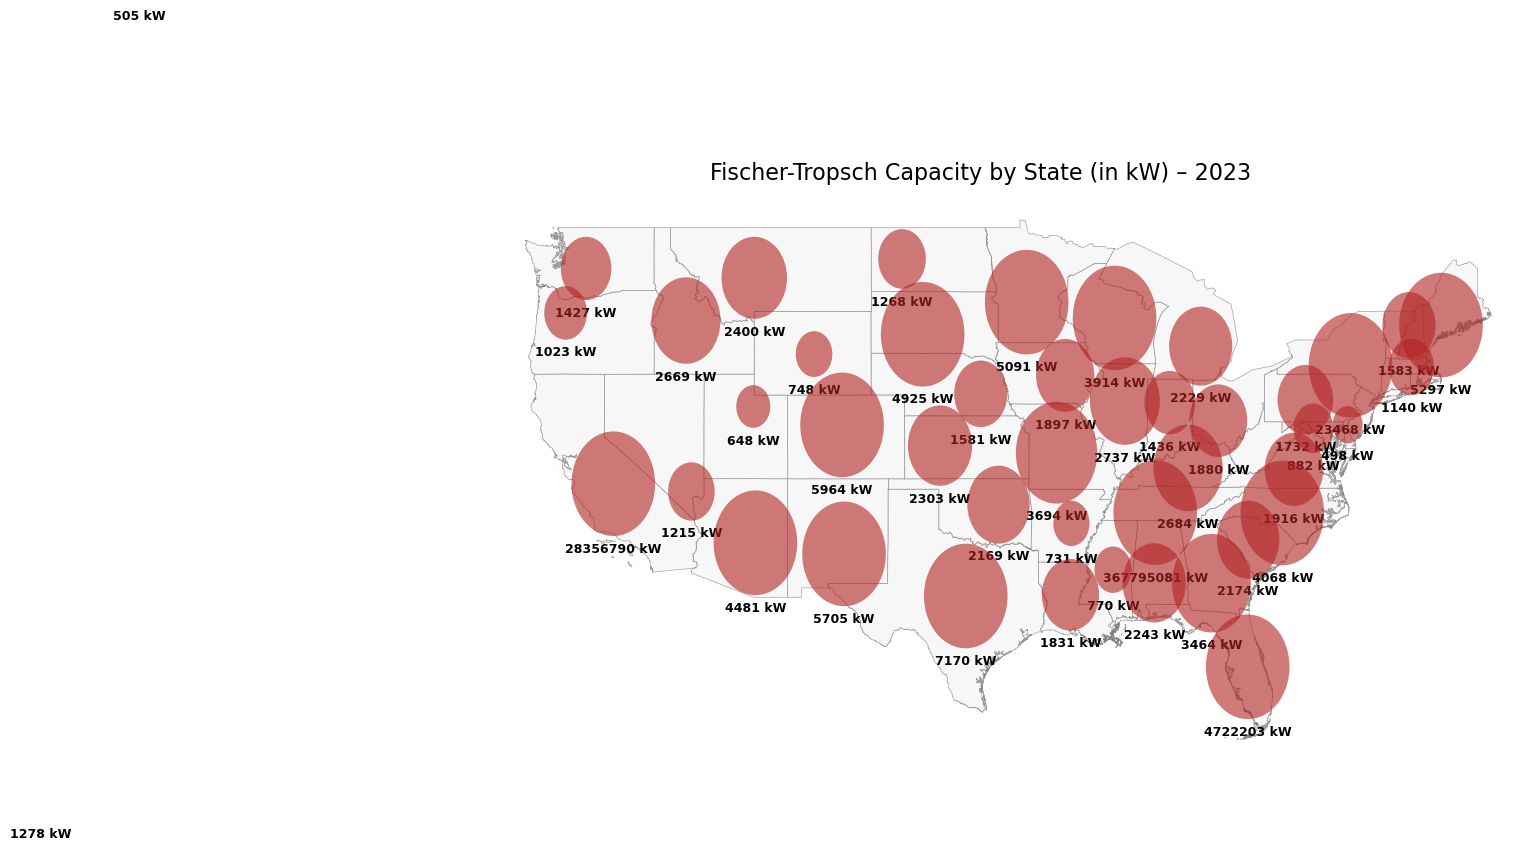

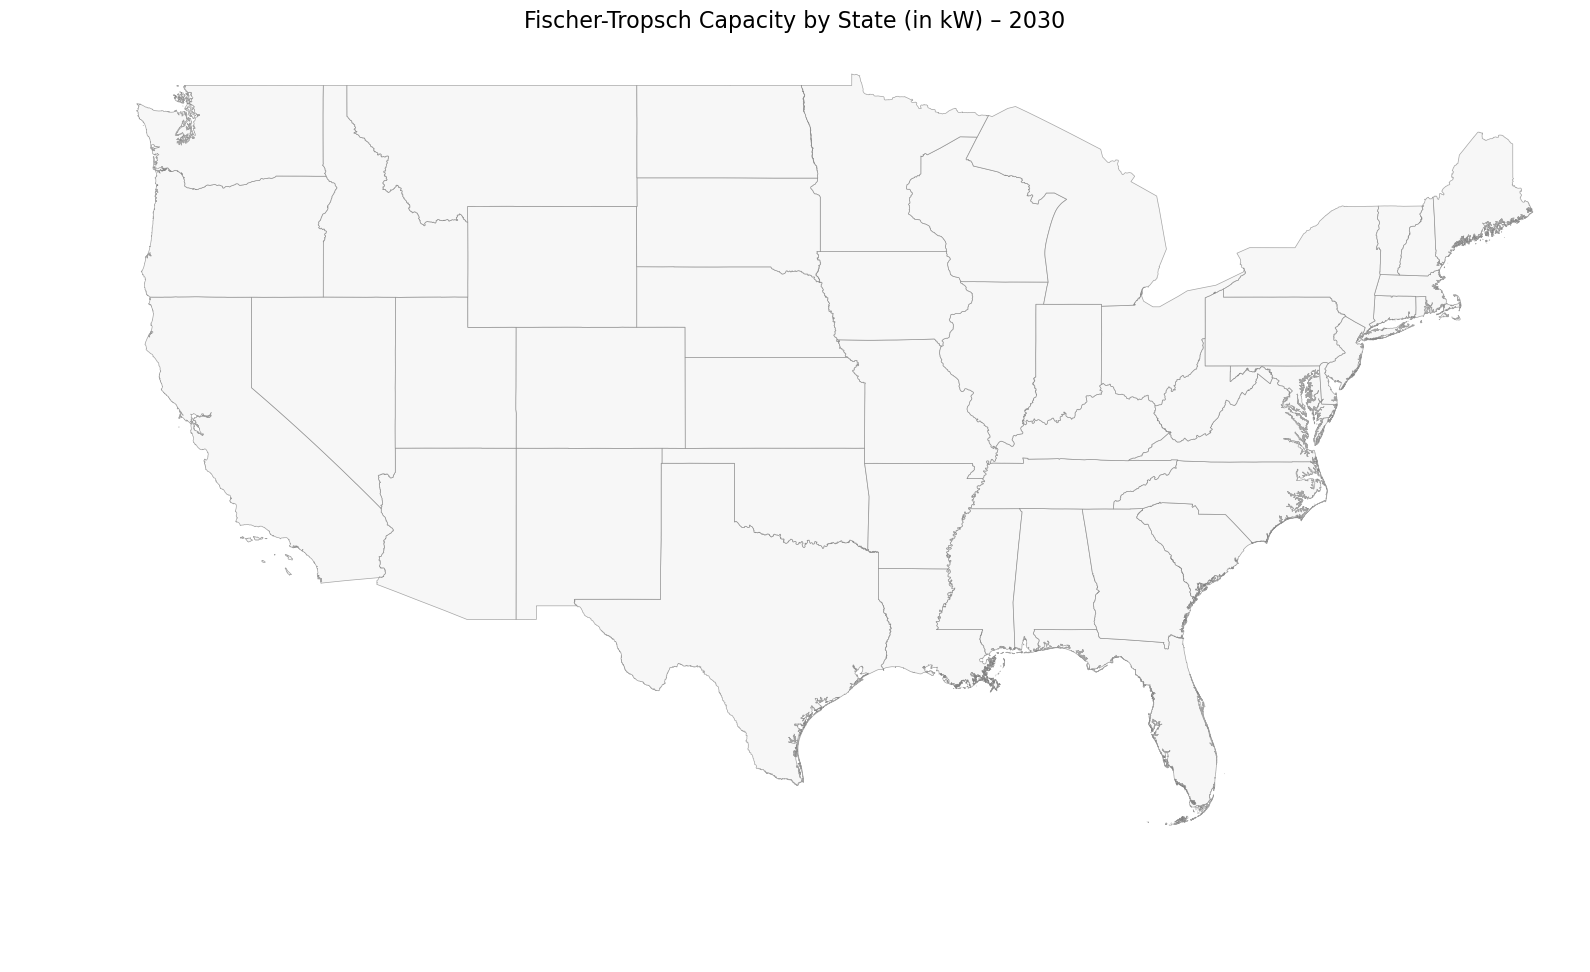

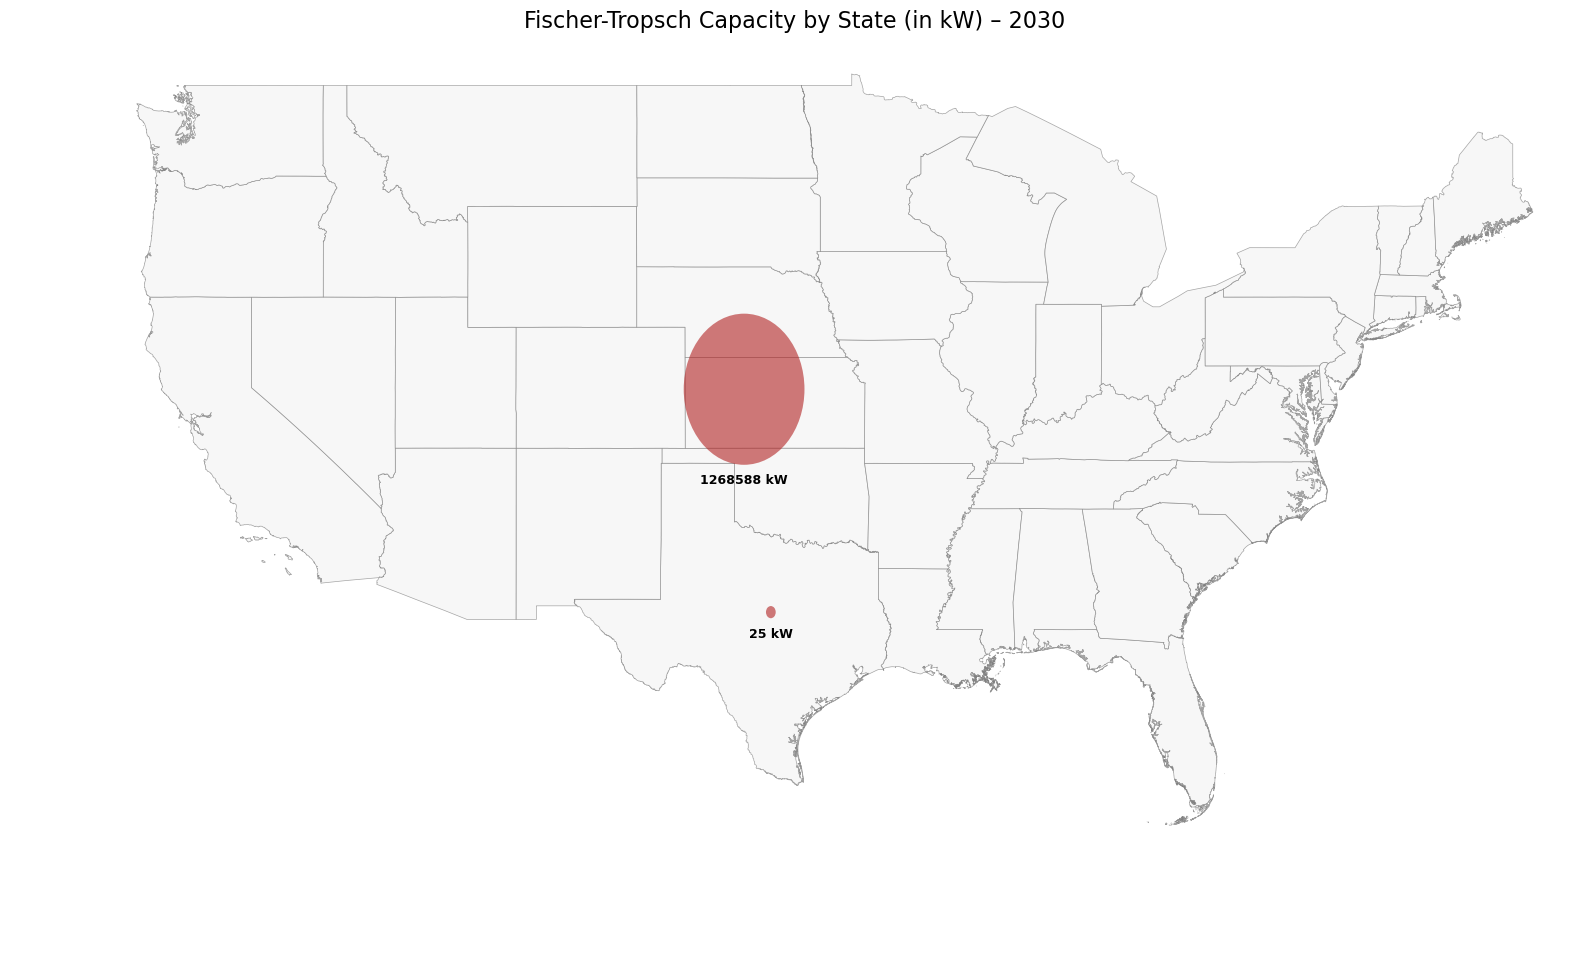

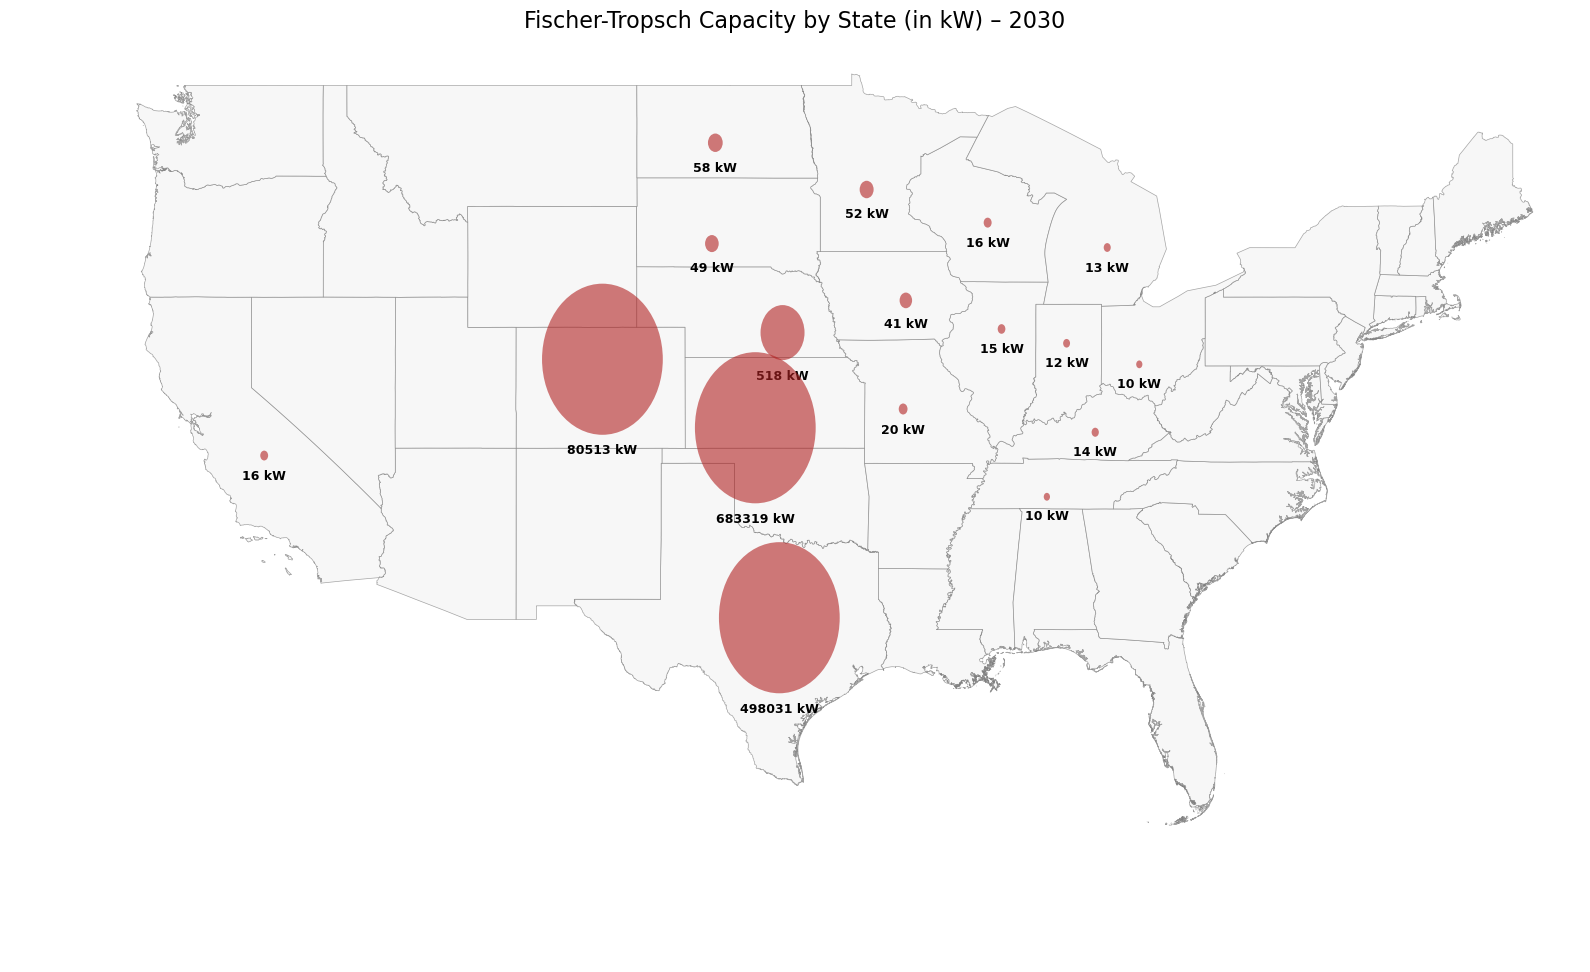

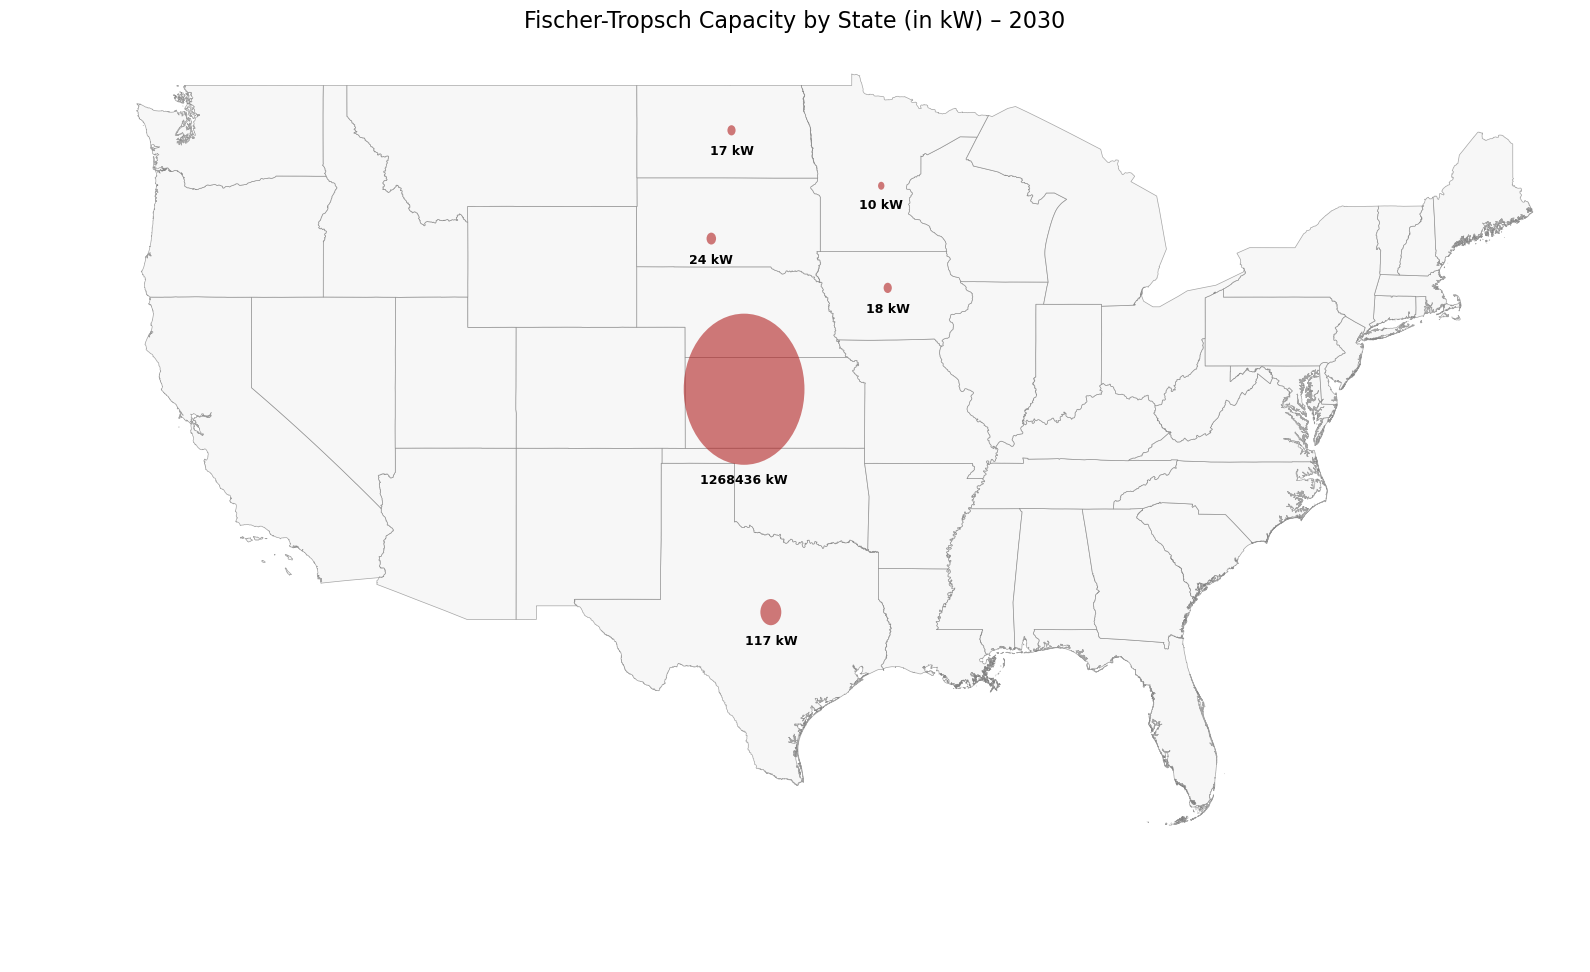

In [32]:
for name, net in networks.items():
    print(f"Plotting FT map for: {name}")
    fig, ax, data = create_ft_capacity_map(
        net.copy(),
        path_shapes=state_shapes_path,
        network_name=name,
        min_capacity_kw=10
    )

In [33]:
def create_ft_capacity_by_grid_region_map(network, path_shapes, network_name="Network", distance_crs=4326, min_capacity_kw=10):
    """
    Create a map showing total FT capacity per grid region (in kW) as full circles.
    """

    import re

    # Extract year from network name
    year_match = re.search(r'\d{4}', network_name)
    year_str = f" – {year_match.group()}" if year_match else ""

    # Filter FT-related links
    ft_links = network.links[
        network.links['carrier'].str.contains('FT|Fischer|Tropsch', case=False, na=False) |
        network.links.index.str.contains('FT|Fischer|Tropsch', case=False, na=False)
    ].copy()

    if ft_links.empty:
        print(f"No FT links found in the network: {network_name}")
        return None, None, None

    # Merge link data with grid_region, x, y from bus0
    links_with_grid_region = ft_links.merge(
        network.buses[["region", "x", "y"]],
        left_on="bus0",
        right_index=True,
        how="left"
    )
    links_with_grid_region["p_nom_kw"] = links_with_grid_region["p_nom_opt"] * 1000

    # Aggregate capacity per grid region
    grid_region_capacity = links_with_grid_region.groupby("region").agg(
        total_kw=("p_nom_kw", "sum"),
        x=("x", "mean"),
        y=("y", "mean")
    ).reset_index()

    # Filter small values
    grid_region_capacity = grid_region_capacity[grid_region_capacity["total_kw"] >= min_capacity_kw]

    # Set up map
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={"projection": ccrs.PlateCarree()})

    bbox = box(-130, 20, -60, 50)
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes = shapes.to_crs(epsg=4326).clip(bbox)
    shapes.plot(ax=ax, facecolor='whitesmoke', edgecolor='gray', alpha=0.7, linewidth=0.5)

    # Plot circles
    pie_scale = 0.04
    for _, row in grid_region_capacity.iterrows():
        x, y, total_kw = row["x"], row["y"], row["total_kw"]
        radius = np.clip(np.sqrt(total_kw) * pie_scale, 0.1, 2.5)
        circle = plt.Circle((x, y), radius, color='#B22222', alpha=0.6,
                            transform=ccrs.PlateCarree(), zorder=4, linewidth=0)
        ax.add_patch(circle)

        ax.text(x, y - radius - 0.3, f'{int(total_kw)} kW',
                ha='center', va='top', fontsize=9, fontweight='bold',
                transform=ccrs.PlateCarree())

    ax.set_extent([-130, -65, 20, 50], crs=ccrs.PlateCarree())
    ax.set_title(f"Fischer-Tropsch Capacity by Grid Region {year_str}", fontsize=16, pad=20)
    ax.axis('off')
    plt.tight_layout()

    return fig, ax, grid_region_capacity

Plotting FT map by grid region: Base_2023
Plotting FT map by grid region: scenario_01_2030
Plotting FT map by grid region: scenario_02_2030
Plotting FT map by grid region: scenario_06_2030
Plotting FT map by grid region: scenario_10_2030


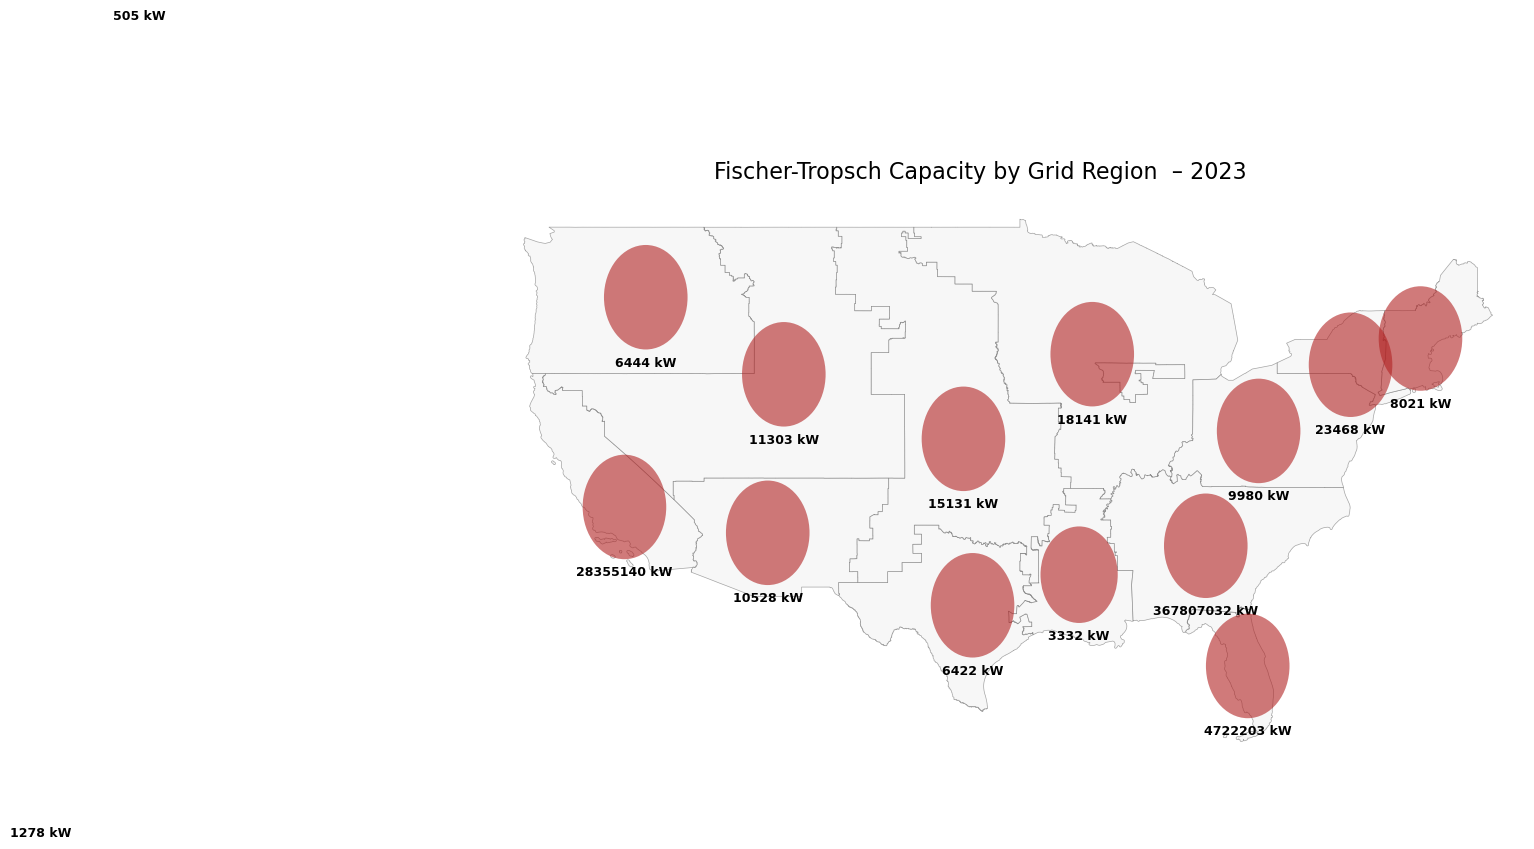

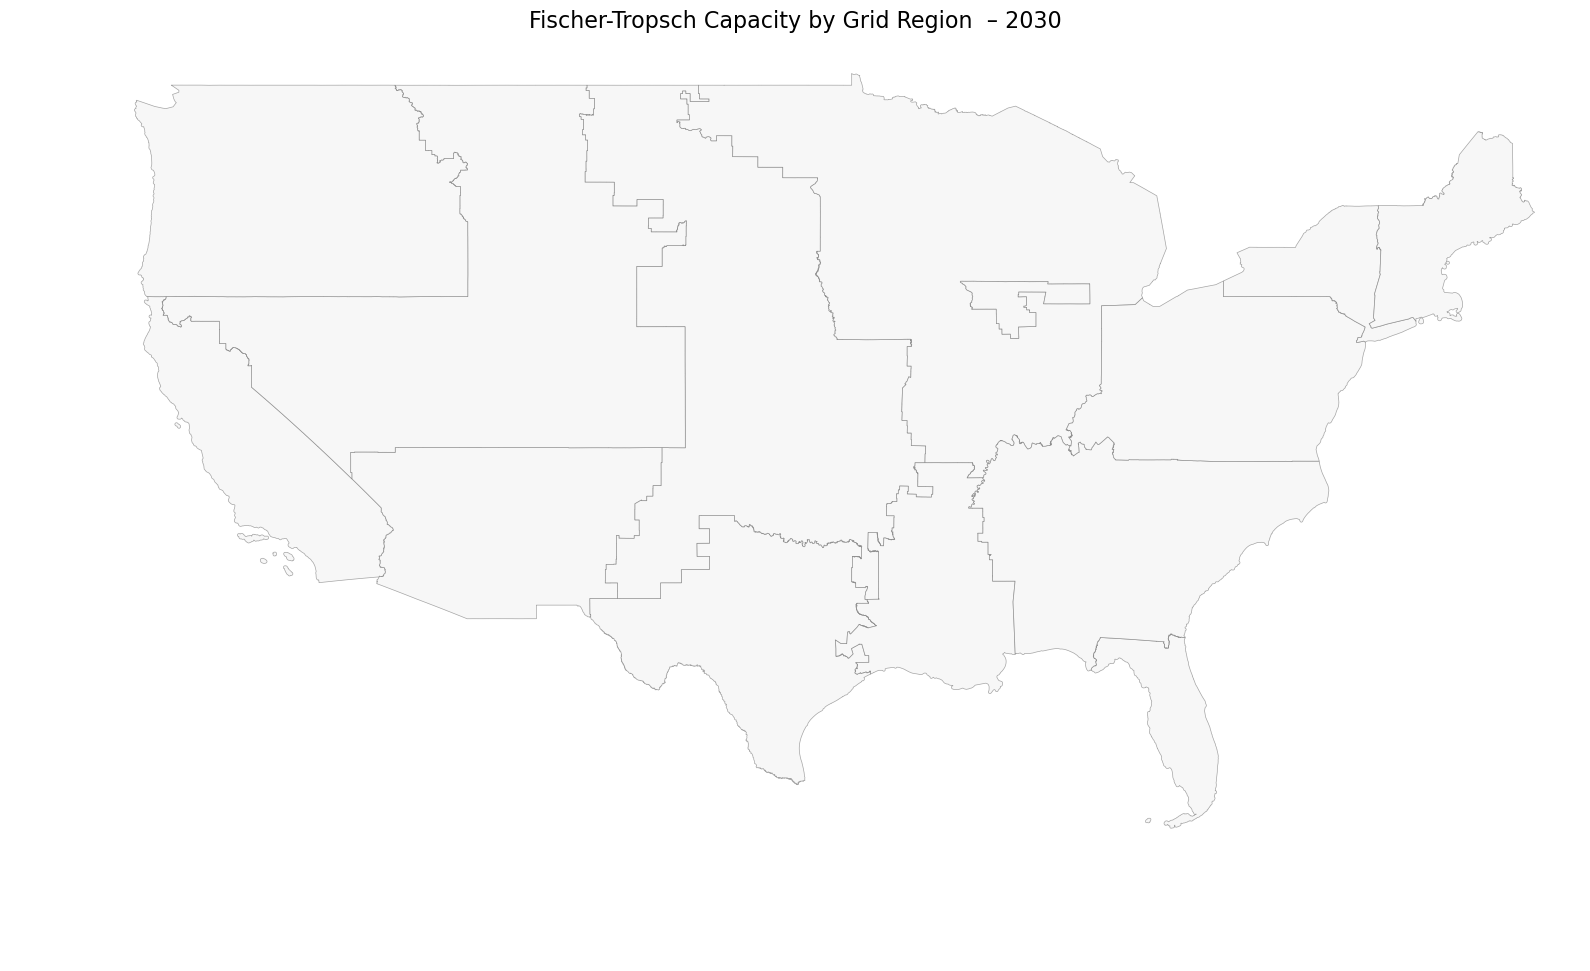

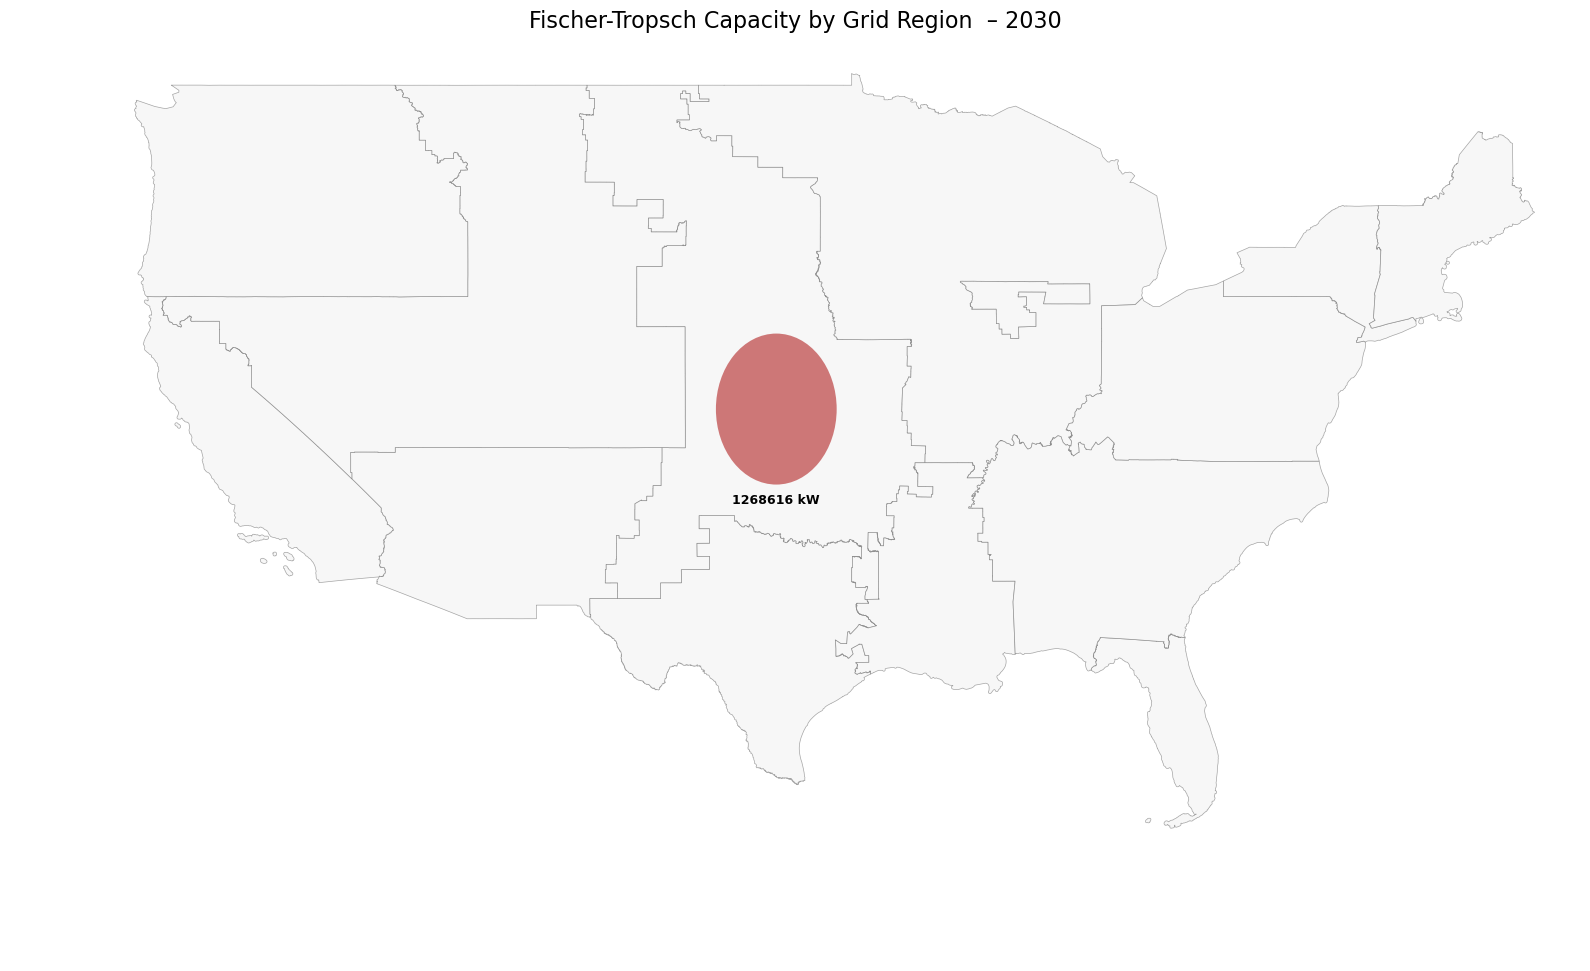

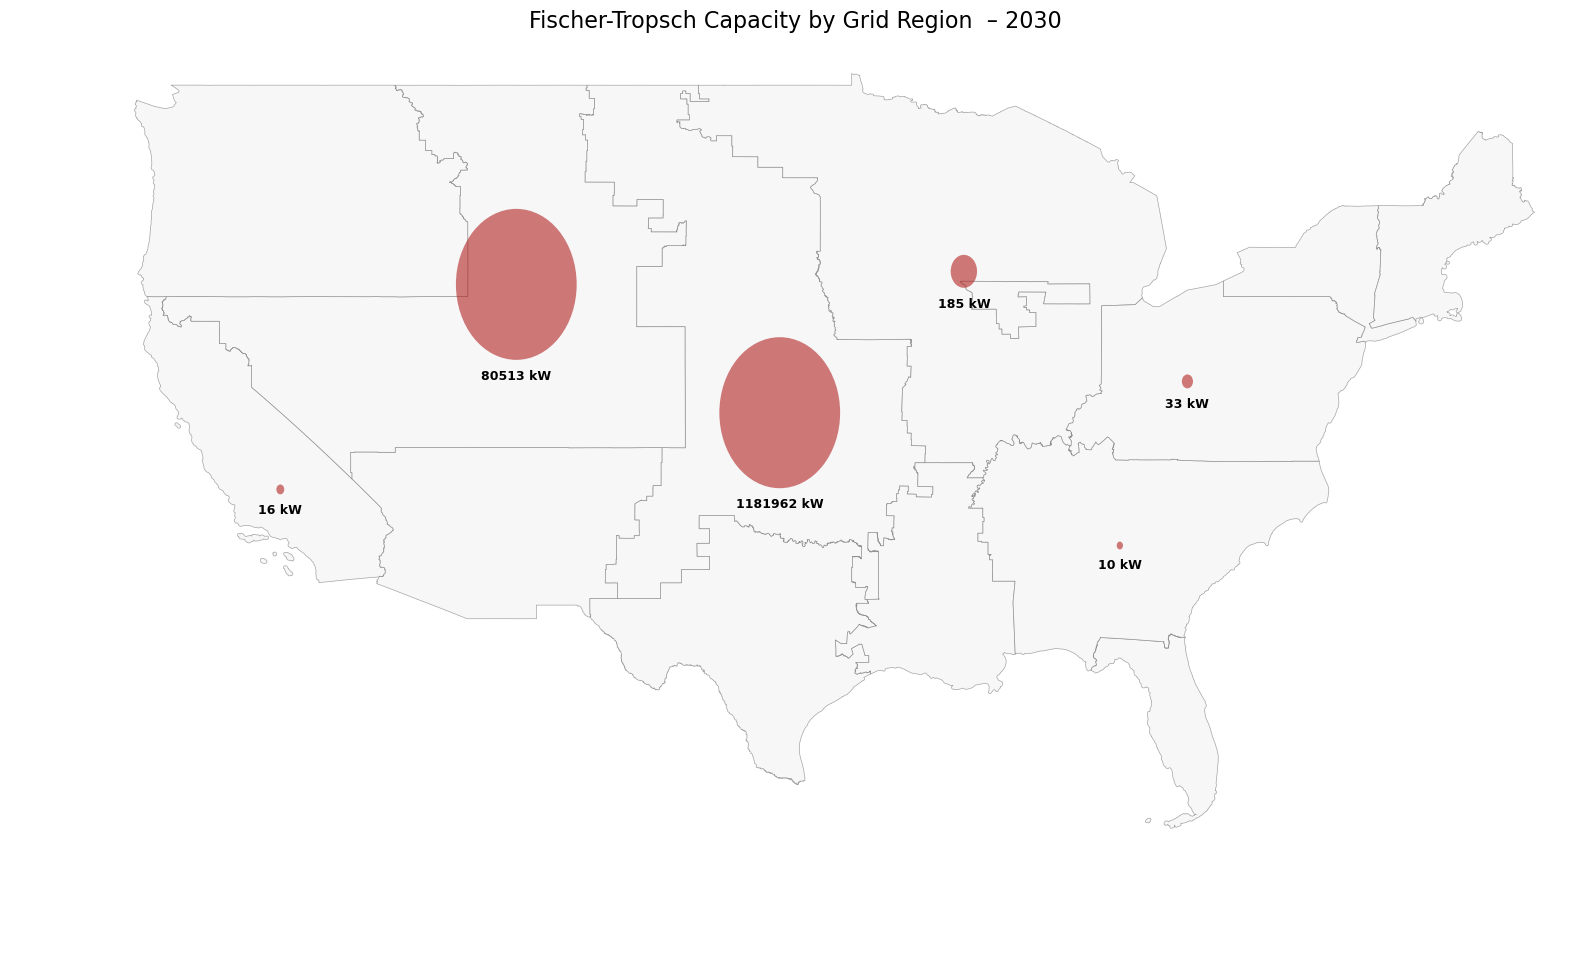

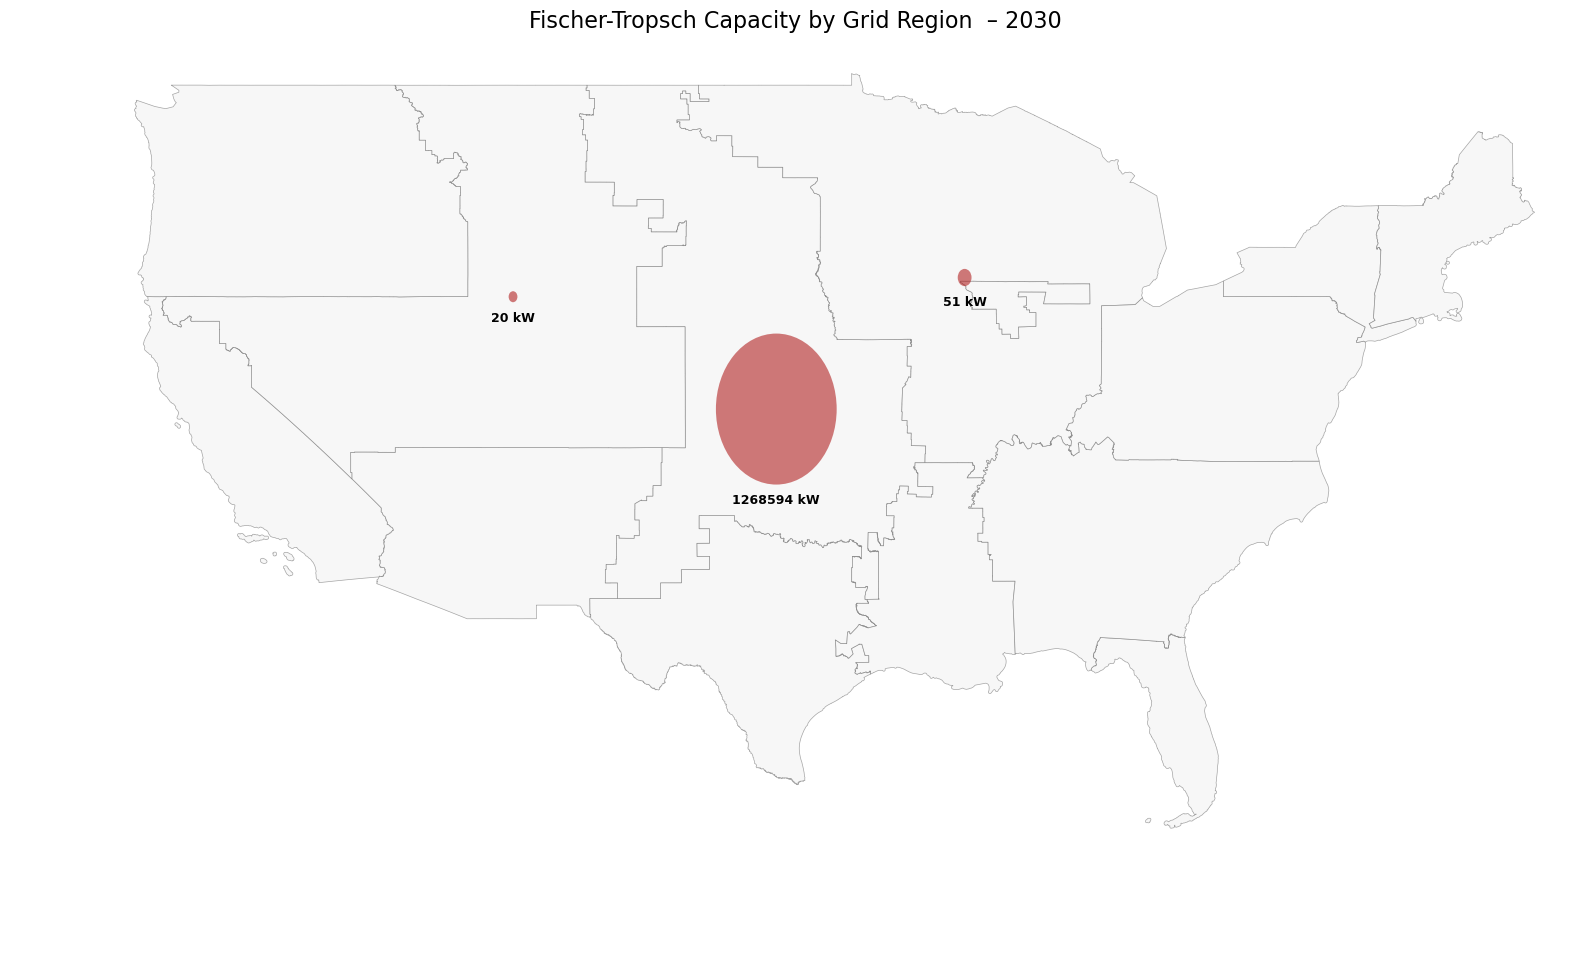

In [34]:
for name, net in networks.items():
    print(f"Plotting FT map by grid region: {name}")
    fig, ax, data = create_ft_capacity_by_grid_region_map(
        net.copy(),
        path_shapes=grid_region_shapes_path,
        network_name=name,
        min_capacity_kw=10
    )

### 4.4. Map: Expanded Capacity per Planning Horizon
*This analysis focuses only on the **newly added** capacity for key technologies (Electricity, H2, FT) within the planning period, rather than the total capacity.*

In [35]:
# Code to calculate the difference between p_nom_opt and p_nom
# and plot the expansion on a map.
pass

---

## 5. Operational Analysis: How Does the System Work?

*This section explores the temporal dispatch of different technologies to meet demand throughout the year.*

### 5.1. Annual Electricity & Hydrogen Dispatch
*A line plot showing the generation from different carriers (for electricity) and production from electrolyzers (for hydrogen) for every hour of the year. This reveals the operational dynamics and intermittency management.*

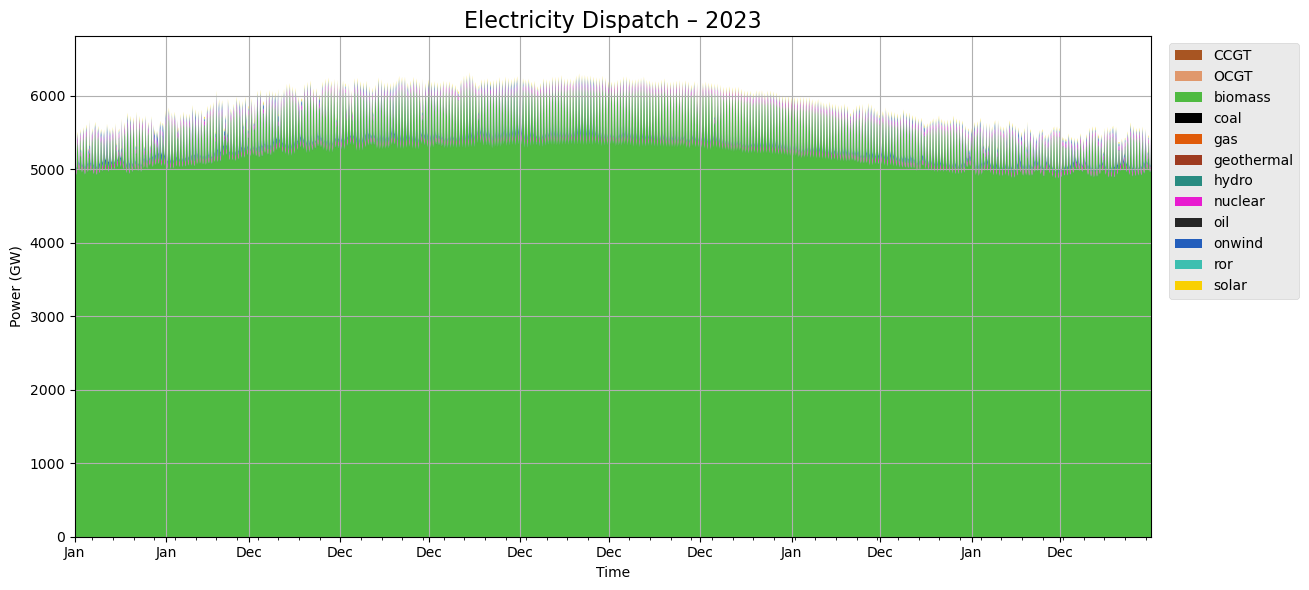

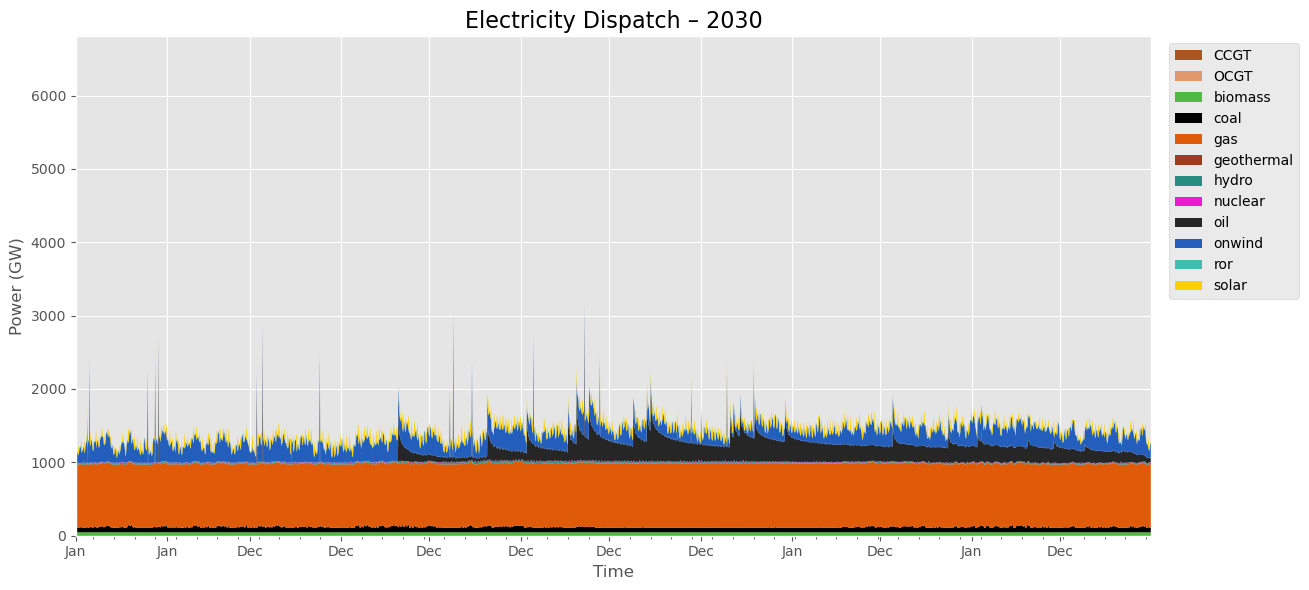

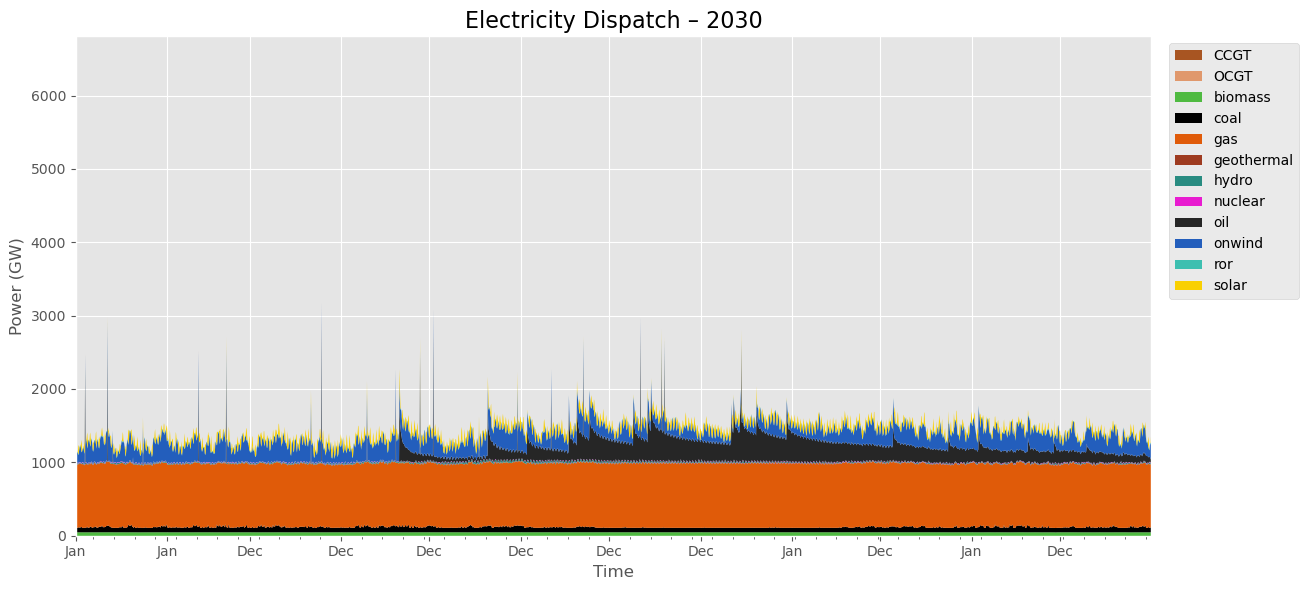

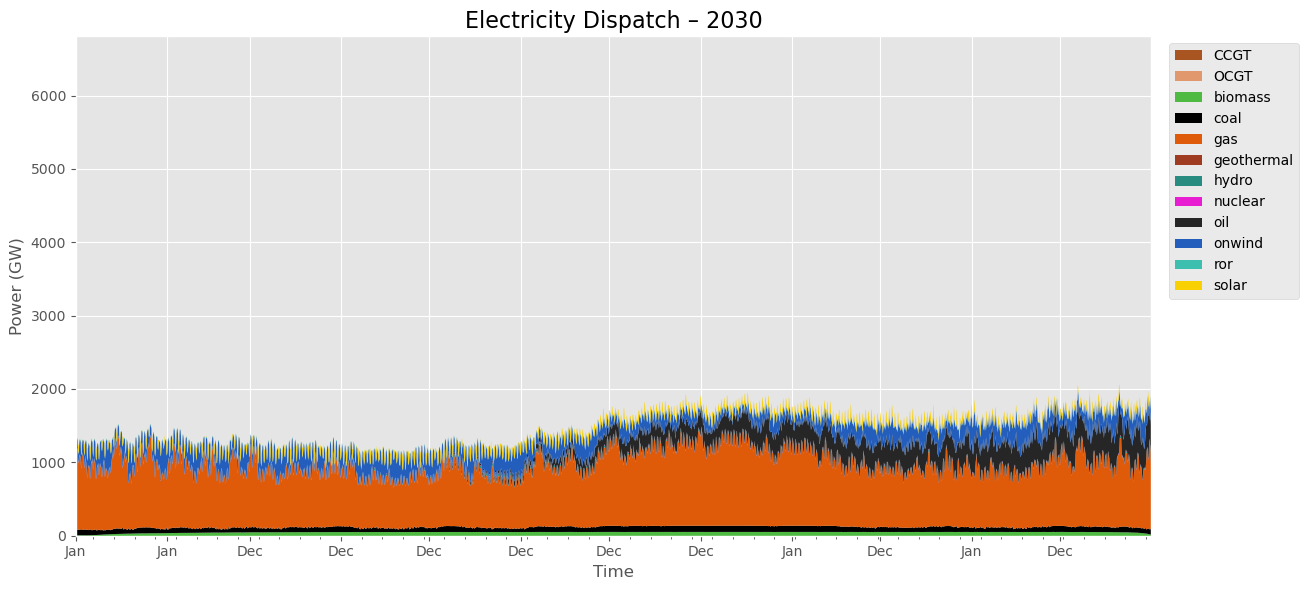

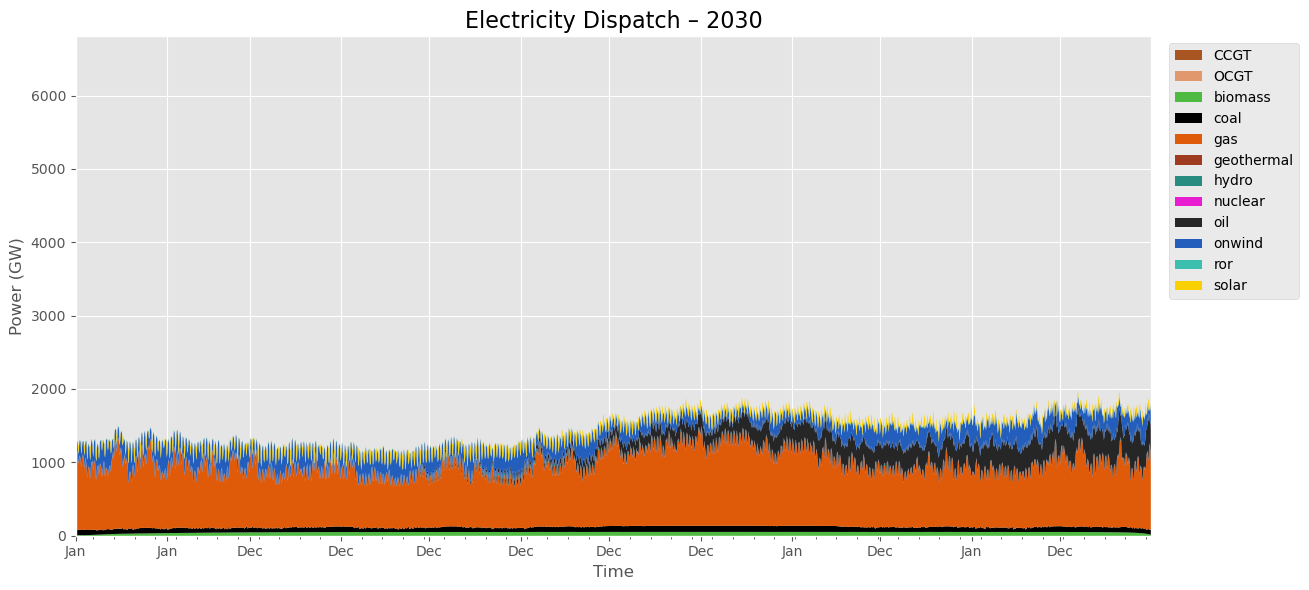

In [36]:
max_val = 0
for net in networks.values():
    total = net.generators_t.p.clip(lower=0).sum(axis=1) + \
            net.storage_units_t.p.clip(lower=0).sum(axis=1) + \
            net.links_t.p1.clip(lower=0).sum(axis=1)
    max_val = max(max_val, total.max())

ymax = max_val / 1e3  # MW → GW

for key, net in networks.items():
    plot_electricity_dispatch(net, tech_colors, key=key, ymax=ymax)

---

## 6. Economic Analysis: What Are the Unit Costs?

*We break down the system costs to find the levelized cost of key energy vectors in different locations.*

### 6.1. Map: Levelized Cost of Electricity (LCOE)
*A map displaying the LCOE at different buses. This shows the all-in cost of producing electricity at various points in the network.*

In [37]:
shapes = gpd.read_file(grid_region_shapes_path)

In [38]:
networks.keys()

dict_keys(['Base_2023', 'scenario_01_2030', 'scenario_02_2030', 'scenario_06_2030', 'scenario_10_2030'])

In [39]:
n = networks["Base_2023"].copy()

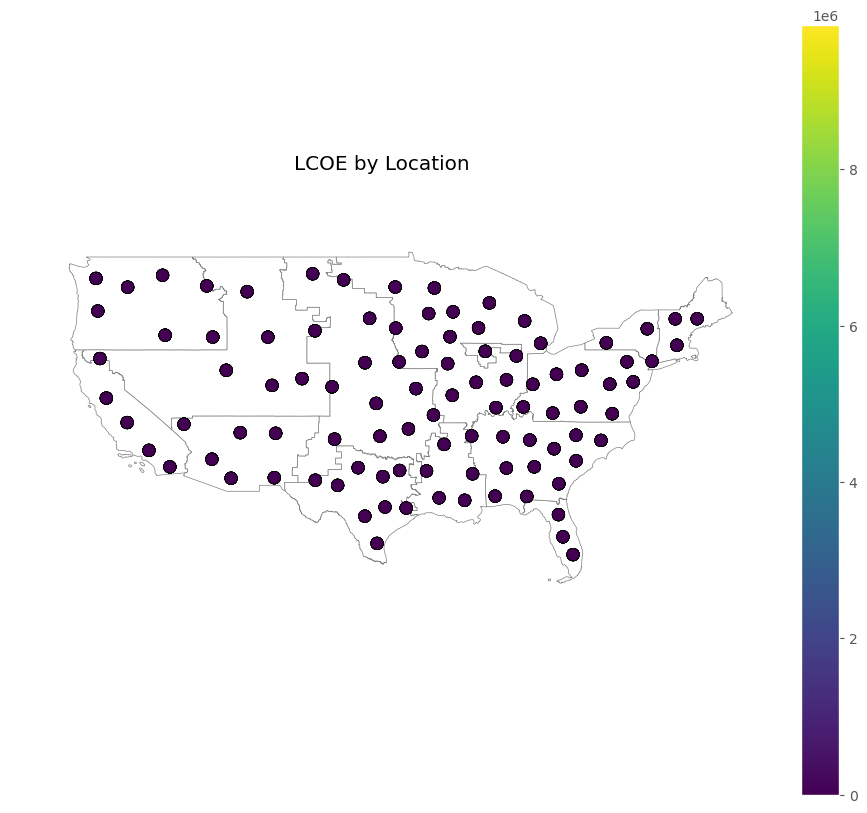

In [40]:
# Assume: generator has attributes capital_cost, marginal_cost, p_nom_opt, and p (power output time-series)

gen = n.generators
dispatch = n.generators_t.p  # hourly power generation

# Total energy generated (MWh)
energy = dispatch.sum(axis=0) * n.snapshot_weightings.generators.sum() / 1e3  # convert to GWh or MWh if needed

# LCOE = (Annualized Capital + Operating) / Energy
lcoe = (gen.capital_cost * gen.p_nom_opt + gen.marginal_cost * energy) / energy
lcoe = lcoe.replace(np.inf, np.nan).dropna()

gen['lcoe'] = lcoe
lcoe_data = gen[['bus', 'lcoe', 'carrier']]
lcoe_data = lcoe_data.merge(n.buses[['x', 'y']], left_on='bus', right_index=True)
lcoe_data["clean_bus"] = lcoe_data.bus.str.extract(r"(US\d{1} \d{1,2})")
lcoe_data['region'] = lcoe_data.clean_bus.map(n.buses.region)

# Create GeoDataFrame from bus points
geometry = [Point(xy) for xy in zip(lcoe_data['x'], lcoe_data['y'])]
lcoe_gdf = gpd.GeoDataFrame(lcoe_data, geometry=geometry, crs=shapes.crs)
lcoe_gdf = lcoe_gdf.to_crs(shapes.crs)

fig, ax = plt.subplots(figsize=(12, 10))
shapes.plot(ax=ax, color='white', edgecolor='gray')  # Plot the regions

# Scatter LCOE points
lcoe_gdf.plot(
    ax=ax,
    column='lcoe',  # This is the value you're mapping
    cmap='viridis',
    legend=True,
    markersize=80,
    edgecolor='black'
)
plt.xlim([-130, -65])
plt.ylim([20, 55])
plt.title("LCOE by Location")
plt.axis('off')
plt.show()

In [41]:
lcoe_data.groupby(['region', 'carrier'])['lcoe'].sum().unstack()

carrier         biomass       coal  csp         gas  offwind-ac  offwind-dc  \
region                                                                        
Alaska         5.010553   5.310382  0.0    8.829914         0.0         0.0   
California    20.037082   0.000000  0.0   35.318644         0.0         0.0   
Delta         25.050144  21.244055  0.0   44.152075         0.0         0.0   
Florida       15.028719  10.622154  0.0   26.489923         0.0         0.0   
Hawaii         5.009190   0.000000  0.0    8.830570         0.0         0.0   
Mid-Atlantic  55.110298  58.424640  0.0   97.136370         0.0         0.0   
Midwest       90.180128  74.359419  0.0  158.942736         NaN         NaN   
Mountain      35.067444  31.868708  0.0   61.814133         0.0         0.0   
New England   15.027929   0.000000  0.0   26.491065         0.0         0.0   
New York      15.029907   0.000000  0.0   26.490571         0.0         0.0   
Northwest     35.070836  10.622237  0.0   61.810818         0.0         0.0   
Plains        60.120065  42.491724  0.0  105.961563         0.0         0.0   
Southeast     60.119285  53.113648  0.0  105.964610         0.0         0.0   
Southwest     30.060725   5.311107  0.0   52.982595         NaN         NaN   
Texas         40.082754  21.244167  0.0   70.643076         0.0         0.0   

carrier              oil      onwind  residential rural solar thermal  \
region                                                                  
Alaska          0.000000   -4.053454                        56.842686   
California    119.855585  117.023649                        63.195235   
Delta           0.000000    0.000000                       128.405946   
Florida        89.893657    0.000000                        73.831752   
Hawaii          0.000000   -9.803496                        22.685755   
Mid-Atlantic  209.749582   17.534690                       324.004895   
Midwest        29.964305 -124.612039                       536.807924   
Mountain       29.964594   17.021475                       145.375524   
New England    29.964746   -0.543509                       104.927045   
New York       89.891609    0.874341                        97.990158   
Northwest       0.000000  122.007971                       179.199988   
Plains         29.964648 -108.658431                       304.607006   
Southeast      59.927155   21.733177                       317.898492   
Southwest      29.964057   78.727182                       102.655069   
Texas           0.000000  -46.213938                       187.201933   

carrier       residential urban decentral solar thermal  ...  \
region                                                   ...   
Alaska                                        40.423953  ...   
California                                    40.588117  ...   
Delta                                         97.565908  ...   
Florida                                       57.371216  ...   
Hawaii                                        14.076651  ...   
Mid-Atlantic                                 238.576739  ...   
Midwest                                      386.547575  ...   
Mountain                                      97.009976  ...   
New England                                   75.459448  ...   
New York                                      65.645827  ...   
Northwest                                    124.264427  ...   
Plains                                       213.699613  ...   
Southeast                                    240.482479  ...   
Southwest                                     68.451879  ...   
Texas                                        143.273424  ...   

carrier       services urban decentral solar thermal      solar  \
region                                                            
Alaska                                     40.043214   4.245269   
California                                 44.189984 -41.580803   
Delta                                      93.669070 -18.

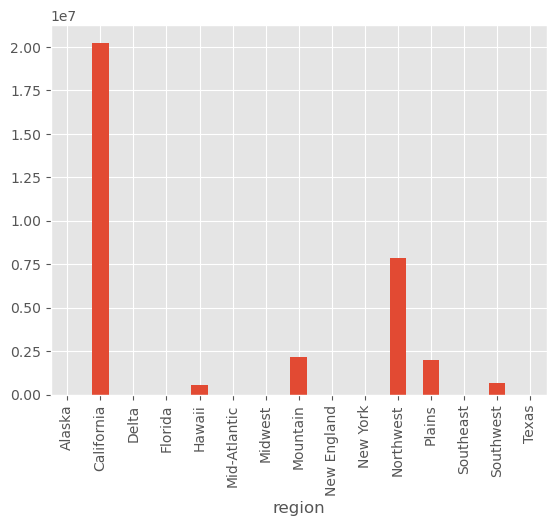

In [42]:
lcoe_data.groupby("region")["lcoe"].sum().plot(kind='bar')
plt.show()

### 6.2. Map: Levelized Cost of Hydrogen (LCOH)
*A map displaying the LCOH at buses where hydrogen is produced. This is a critical metric for the hydrogen economy.*

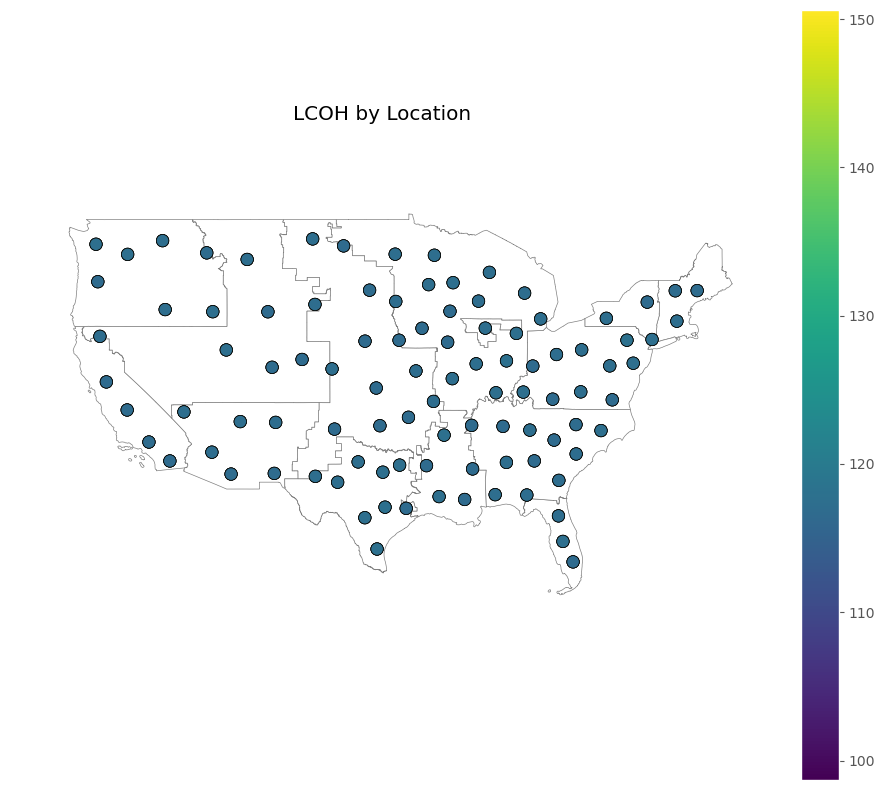

In [43]:
h2_carriers = ["Alkaline electrolyzer large", "Alkaline electrolyzer medium",
            "Alkaline electrolyzer small", "PEM electrolyzer", "SOEC"]

hydrogen_links = n.links.query("carrier in @h2_carriers")
hydrogen_dispatch = n.links_t.p0[hydrogen_links.index]  # p0 is power input to electrolyzers

# Total H2 energy output: p1 is H2 output
h2_output = -n.links_t.p1[hydrogen_links.index].sum(axis=0)

lcoh = (hydrogen_links.capital_cost * hydrogen_links.p_nom_opt + hydrogen_links.marginal_cost * h2_output) / h2_output

hydrogen_links['lcoh'] = lcoh
lcoh_data = hydrogen_links[['bus0', 'lcoh', 'carrier']]
lcoh_data = lcoh_data.merge(n.buses[['x', 'y']], left_on='bus0', right_index=True)
lcoh_data['region'] = lcoh_data.bus0.map(n.buses.region)

# Create GeoDataFrame from bus points
geometry = [Point(xy) for xy in zip(lcoh_data['x'], lcoh_data['y'])]
lcoh_gdf = gpd.GeoDataFrame(lcoh_data, geometry=geometry, crs=shapes.crs)
lcoh_gdf = lcoh_gdf.to_crs(shapes.crs)

fig, ax = plt.subplots(figsize=(12, 10))
shapes.plot(ax=ax, color='white', edgecolor='gray')  # Plot the regions

# Scatter LCOE points
lcoh_gdf.plot(
    ax=ax,
    column='lcoh',  # This is the value you're mapping
    cmap='viridis',
    legend=True,
    markersize=80,
    edgecolor='black'
)
plt.xlim([-130, -65])
plt.ylim([20, 55])
plt.title("LCOH by Location")
plt.axis('off')
plt.show()

In [44]:
lcoh_data.groupby(['region', 'carrier'])['lcoh'].sum().unstack()

carrier       Alkaline electrolyzer large  PEM electrolyzer         SOEC
region                                                                  
Alaska                         100.564029        150.461136   117.645299
California                     402.628149        601.588955   467.037879
Delta                          502.614621        752.049082   585.209219
Florida                        301.527165        451.057081   351.162458
Hawaii                          98.752946        149.290387   116.795150
Mid-Atlantic                  1106.535452       1655.449336  1288.848172
Midwest                       1809.746890       2707.229619  2108.777484
Mountain                       704.148774       1052.546475   819.104034
New England                    301.218807        451.114723   350.845935
New York                       301.571297        451.057326   351.512372
Northwest                      702.602375       1051.847887   820.106048
Plains                        1206.267908       1804.745538  1403.187510
Southeast                     1206.248045       1804.661274  1403.904214
Southwest                      603.269655        902.379375   702.290839
Texas                          803.664293       1201.932653   938.727306

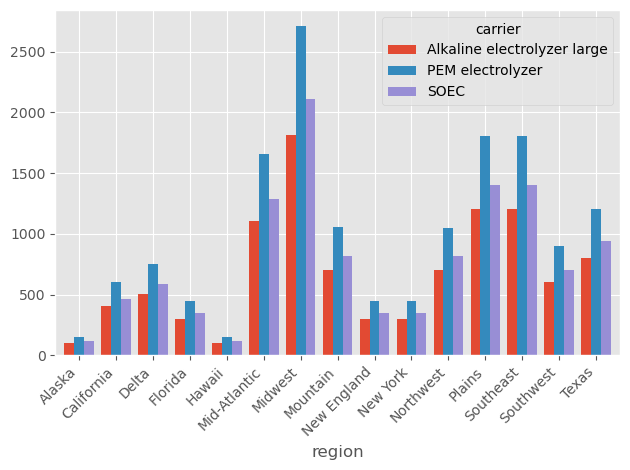

In [45]:
lcoh_data.groupby(['region', 'carrier'])['lcoh'].sum().unstack().plot(
    kind='bar',
    width=0.8
)
ax.set_ylabel('LCOH')
ax.set_xlabel('Region')
ax.set_title('Levelized Cost of Hydrogen (LCOH) by Region and Electrolyzer Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

## 7. Sector-Specific Analysis: E-Kerosene Deep Dive

*A dedicated section to analyze the production chain, costs, and outputs related to synthetic aviation fuel.*

### 7.1. E-Kerosene Production and Costs
*Analysis of the Fischer-Tropsch process, including inputs (H2, CO2), outputs (e-kerosene), and the resulting levelized cost of the fuel.*

In [46]:
# Code to analyze the FT links, their inputs/outputs,
# and calculate the Levelized Cost of Kerosene (LCOK).
pass

---